# Carga de librerias necesarias

%pip install folium   
%pip install geopy   
%pip install geopandas   
%pip install dash-bootstrap-components   
%pip install dash   
%pip install tabulate

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker # per poder utilitzar FuncFormatter i aplicar format a la barra
import geopandas as gpd
import time
import folium
import os
import re
from mysql.connector import errorcode
from dotenv import load_dotenv # type: ignore # per dades accedir base dades
from datetime import datetime
from matplotlib.ticker import FuncFormatter # per poder utilitzar el separador de milersimport geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geopy.exc import GeocoderTimedOut
from folium.plugins import MarkerCluster
from tabulate import tabulate # para formato de una tabla
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

#Librer√≠a para gr√°ficos interactivos en python
import plotly.graph_objects as go
import plotly.express as px

# Descarga de archivo CSV

In [34]:
path = r"..\Data\2025_04_28_Sprint03_bruto.csv"

df = pd.read_csv(path)



# Limpieza

## Comprobar dataset

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 10000 non-null  int64  
 1   name                         9997 non-null   object 
 2   description                  9862 non-null   object 
 3   host_id                      10000 non-null  int64  
 4   neighbourhood_name           10000 non-null  object 
 5   neighbourhood_district       6079 non-null   object 
 6   room_type                    10000 non-null  object 
 7   accommodates                 10000 non-null  int64  
 8   bathrooms                    9926 non-null   float64
 9   bedrooms                     9930 non-null   float64
 10  beds                         9955 non-null   float64
 11  amenities_list               9983 non-null   object 
 12  price                        9746 non-null   float64
 13  minimum_nights   

## Cambio de tipo de datos de fechas

In [36]:
df[['first_review_date','last_review_date','insert_date']]

first_review_date last_review_date insert_date
0           02/01/2010       05/09/2017  31/07/2018
1           10/10/2014       15/07/2018  10/01/2020
2           05/01/2011       22/07/2019  29/07/2019
3           13/03/2012       04/01/2020  10/01/2020
4           08/07/2011       08/08/2018  19/02/2019
...                ...              ...         ...
9995               NaN              NaN  31/01/2021
9996               NaN              NaN  27/02/2021
9997               NaN              NaN  31/01/2021
9998               NaN              NaN  09/02/2021
9999               NaN              NaN  09/02/2021

[10000 rows x 3 columns]

In [37]:
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

df[['first_review_date','last_review_date','insert_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_review_date  7396 non-null   datetime64[ns]
 1   last_review_date   7395 non-null   datetime64[ns]
 2   insert_date        10000 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 234.5 KB


## Duplicados

### Funcion de duplicados

In [38]:
def mantener_fecha_mas_reciente(df, columna_id, columna_fecha):
    """
    Elimina duplicados basados en un ID, manteniendo la fila con la fecha m√°s reciente.
    
    Par√°metros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_id (str): El nombre de la columna que identifica los duplicados.
    columna_fecha (str): El nombre de la columna que contiene las fechas.

    Retorna:
    DataFrame: Un nuevo DataFrame con los IDs √∫nicos y sus fechas m√°s recientes.
    """

    # Ordenar por fecha descendente
    df = df.sort_values(by=columna_fecha, ascending=False)

    # Eliminar duplicados manteniendo el m√°s reciente
    df = df.drop_duplicates(subset=columna_id, keep='last')

    return df



#### Numero de registros duplicados

In [39]:
total_registros = len(df)
valores_unicos = df['apartment_id'].nunique()
duplicados = total_registros - valores_unicos
print(f"Registros duplicados: {duplicados}")
print(f"Registros que deber√≠an quedar: {valores_unicos}")

Registros duplicados: 350
Registros que deber√≠an quedar: 9650


### Ejecutar funcion al dataset con el ID del apartamento y la fecha de insersion 

In [40]:
df = mantener_fecha_mas_reciente(df, columna_id='apartment_id', columna_fecha='insert_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9650 entries, 3092 to 2456
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9514 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9584 non-null   float64       
 9   bedrooms                     9583 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9633 non-null   

In [41]:
df[df['amenities_list'].isna()]

apartment_id                                            name  \
1115       5210987             Single room in Castellana/Chamartin   
1096       5121791                     Genial habitaciÔøΩn en Gracia   
5188      21271313                                   Pol62-Rustica   
3017      15031239  TIPI on the land of Finca s'Almudaina Montuiri   
4970      20562314                               Art Villa S'AgarÔøΩ   
1650       7948633                            Mallorca desconocida   
909        3888649             Apartamento muy centrico y acogedor   
1497       7127848                 Nice appt in Madrid city center   
5232      21418557        Roomspace Sandoval- Glorieta de Bilbao 2   
736        3080652              HABITACION GRANDE CENTRO DE MALAGA   
1998      10749658                  Habitacion doble centro madrid   
897        3826233                         Apartamento con encanto   
2227      12045434                       2bedroom SagradaFamiliaE4   
589        2341293               3 bedrooms + 2bathrooms + terrace   
61          378998                 PRECIOSA Y ACOGEDORA HABITACIÔøΩN   
2746      13958403              Big Room in Gracia close to center   
2643      13722943                         habitacion compartida 2   

                                            description    host_id  \
1115  Very lightfull & modern single room in a luxur...    2563986   
1096  HabitaciÔøΩn grande y balcÔøΩn propio. Muy luminos...   26471057   
5188  The villa is in a rural setting surrounded by ...   98002653   
3017  Sacred place with beautiful surroundings, be d...    5275866   
4970  El Art Villa SÔøΩAgarÔøΩ es una encantadora villa ...  143723965   
1650  La casa estÔøΩ muy cerca del pueblo de Lloseta, ...   41916589   
909   Piso a dos minutos del casco antiguo,y diez mi...   20116128   
1497  Wonderful flat,  3 rooms  in the heart of Madr...   37334057   
5232  Moderno apartamento ubicado en un edificio con...   31772865   
736   Habitacion grande con un balcÔøΩn a la calle en ...     977031   
1998  Habitacion luminosa y exterior, cama matrimoni...   55578078   
897   Apartamento en el corazÔøΩn del barrio gÔøΩtico . ...    3741501   
2227  Apartment recently renovated where modern elem...    7414663   
589   Apartment in Barcelona Eixample with 3 bedroom...      71615   
61    HabitaciÔøΩn limpia y luminosa con cama individu...    1903257   
2746  I rent a nice big room with bed, garderobe and...   37675018   
2643          Mi alojamiento es bueno para aventureros.   78488982   

                      neighbourhood_name neighbourhood_district  \
1115                      HispanoamÔøΩrica              ChamartÔøΩn   
1096                   la Vila de GrÔøΩcia                 GrÔøΩcia   
5188                            PollenÔøΩa                    NaN   
3017                            MontuÔøΩri                    NaN   
4970                Castell-Platja d'Aro                    NaN   
1650                             Lloseta                    NaN   
909                Ciutadella de Menorca                    NaN   
1497                         Embajadores                 Centro   
5232                           Trafalgar               ChamberÔøΩ   
736                               Centro                    NaN   
1998                            Arapiles               ChamberÔøΩ   
897                       el Barri GÔøΩtic           Ciutat Vella   
2227          el Camp de l'Arpa del Clot             Sant MartÔøΩ   
589   el Camp d'en Grassot i GrÔøΩcia Nova                 GrÔøΩcia   
61         Vilapicina i la Torre Llobeta             Nou Barris   
2746                   la Vila de GrÔøΩcia                 GrÔøΩcia   
2643              Sant Gervasi - Galvany    SarriÔøΩ-Sant Gervasi   

            room_type  accommodates  bathrooms  bedrooms  ...  \
1115     Private room             1        1.0       1.0  ...   
1096     Private room             1        1.0       1.0  ...   
5188  Entire home/apt       

## Normalizacion de "Amenities"

In [ ]:
# Paso 1: Limpieza
df['amenities_list'] = df['amenities_list'].fillna('not available')
df['amenities_list'] = df['amenities_list'].apply(
    lambda x: [a.strip() for a in x.split(',')] if isinstance(x, str) else ['not available'])


def clean_amenity_list(lst):
    return [re.sub(r'[\[\]]', '', a.strip().lower()) for a in lst if a.strip()]

df['amenities_list'] = df['amenities_list'].apply(clean_amenity_list)

# Paso 2: Extraer amenities √∫nicas
all_amenities = [item for sublist in df['amenities_list'] for item in sublist]
unique_amenities = sorted(set(all_amenities))

# Paso 3: Vectorizar
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
X = vectorizer.fit_transform(unique_amenities)

# Paso 4: Calcular similitud y distancia
similarity = cosine_similarity(X)
distance_matrix = np.clip(1 - similarity, 0, 1)

# Paso 5: Clustering con DBSCAN
clustering = DBSCAN(eps=0.3, min_samples=1, metric='precomputed')
labels = clustering.fit_predict(distance_matrix)

# Paso 6: Crear DataFrame y exportar
cluster_df = pd.DataFrame({'cluster_id': labels, 'amenity': unique_amenities
                           }).sort_values(by='cluster_id')

# Mostrar los grupos
cluster_view = defaultdict(list)
for label, amenity in zip(labels, unique_amenities):
    cluster_view[label].append(amenity)

# Contar cu√°ntos grupos √∫nicos hay
num_clusters = len(set(labels))
print(f"\nDe momento hay {len(unique_amenities)} comodidades √∫nicas, dentro de {num_clusters} grupos provicionales.")

view_text = "\n".join(
    f"Grupo {cluster_id + 1}:\n" + ", ".join(sorted(group))
    for cluster_id, group in sorted(cluster_view.items()))

print(view_text)


De momento hay 275 comodidades √∫nicas, dentro de 219 grupos provicionales.
Grupo 0:

Grupo 1:
24-hour check-in
Grupo 2:
40 hdtv, hdtv
Grupo 3:
43 hdtv with netflix
Grupo 4:
accessible-height bed, accessible-height toilet
Grupo 5:
air conditioning, central air conditioning, portable air conditioning
Grupo 6:
amazon echo
Grupo 7:
baby bath
Grupo 8:
baby monitor
Grupo 9:
baby safety gates
Grupo 10:
babysitter recommendations
Grupo 11:
baking sheet
Grupo 12:
balcony, patio or balcony
Grupo 13:
barbecue utensils
Grupo 14:
bath towel
Grupo 15:
bathroom essentials, beach essentials, essentials
Grupo 16:
bathtub, bathtub with bath chair
Grupo 17:
bbq grill
Grupo 18:
beach view
Grupo 19:
beachfront
Grupo 20:
bed linens
Grupo 21:
bedroom comforts
Grupo 22:
bidet
Grupo 23:
bluetooth sound system, ikea nearby bluetooth sound system, sound system
Grupo 24:
body soap, rituals body soap
Grupo 25:
bread maker
Grupo 26:
breakfast, breakfast bar, breakfast table
Grupo 27:
building staff
Grupo 28:
buzz

#### Diccionario de equivalencias 

In [11]:
equivalencias = {
('24-hour check-in'): ['24-hour check-in', 'building staff', 'doorman', 'doorman entry', 'front desk/doorperson', 'host greets you'],
('air conditioning'): ['air conditioning', 'central air conditioning', 'central heating', 'heated floors', 'heating', 'ceiling fan', 'portable fans', 'portable heater'],
('baby essentials'): ['baby bath', 'baby essentials', 'baby monitor', 'baby safety gates', 'changing table', 'high chair', 'crib', 'pack u2019n play/travel crib', 'pack ÔøΩn play/travel crib'],
('balcony'): ['balcony', 'patio or balcony', 'terrace'],
('barbecue utensils'): ['barbecue utensils', 'bbq grill'],
('bathroom essentials'): ['bath towel', 'bathroom essentials', 'beach essentials', 'essentials', 'body soap', 'conditioner', 'rituals body soap', 'rituals shampoo', 'shampoo', 'shower gel', 'toilet', 'toilet paper'],
('bathroom extras'): ['bidet', 'dryer', 'hair dryer', 'en suite bathroom', 'drying rack for clothing', 'heated towel rack', 'touchless faucets'],
('bathtub'): ['bathtub', 'hot tub', 'soaking tub'],
('beach view'): ['beach view', 'beachfront', 'waterfront'],
('bedroom estras'): ['bedroom comforts', 'bed linens', 'day bed', 'extra pillows and blankets'],
('sound system'): ['amazon echo', 'bluetooth sound system', 'ikea nearby bluetooth sound system', 'sound system'],
('buzzer/wireless intercom'): ['buzzer/wireless intercom'],
('cleaning before checkout'): ['cleaning before checkout', 'cleaning products'],
('storage'): ['clothing storage', 'clothing storage: closet', 'hangers', 'luggage dropoff allowed', 'standing valet'],
('coffee maker'): ['coffee maker', 'espresso machine', 'nespresso machine', 'pour over coffee', 'pour-over coffee'],
('elevator'): ['elevator', 'elevator in building'],
('internet'): ['ethernet connection', 'internet', 'wireless internet', 'wifi', 'wifi u2013 100 mbps', 'pocket wifi'],
('ev charger'): ['ev charger'],
('exercise equipment'): ['exercise equipment', 'gym'],
('family friendly'): ['babysitter recommendations', 'childrenu2019s books and toys', 'childrenÔøΩs books and toys', 'childrenu2019s dinnerware', 'childrenÔøΩs dinnerware', 'family/kid friendly', 'lock on bedroom door', 'table corner guards', 'window guards'],
('fire extinguisher'): ['fire extinguisher'],
('smoke detector'): ['carbon monoxide alarm', 'carbon monoxide detector', 'smoke alarm', 'smoke detector'],
('fireplace guards'): ['fireplace guards'],
('custom bed'): ['firm mattress', 'memory foam mattress', 'pillow-top mattress', 'murphy bed'],
('first aid kit'): ['first aid kit'],
('game console'): ['game console'],
('garden'): ['garden or backyard', 'shared garden or backyard'],
('indoor fireplace'): ['indoor fireplace'],
('ironing board'): ['iron', 'ironing board'],
('kitchen'): ["chef's kitchen", 'full kitchen', 'kitchen', 'kitchenette'],
('kitchen essentials'): ['baking sheet', 'cooking basics', 'dishes and silverware', 'wine glasses', 'bread maker', 'dishwasher', 'freezer', 'microwave', 'mini fridge', 'refrigerator', 'rice maker', 'toaster', 'hot water', 'hot water kettle'],
('dining area'): ['breakfast', 'breakfast table', 'dining area', 'dining table', 'formal dining area', 'outdoor dining area'],
('lake access'): ['lake access'],
('long term stays allowed'): ['long term stays allowed'],
('mosquito net'): ['mosquito net'],
('mountain view'): ['mountain view'],
('mudroom'): ['mudroom'],
('other'): ['other'],
('outdoor furniture'): ['hammock', 'outdoor furniture', 'outdoor seating', 'outlet covers', 'sun loungers'],
('oven'): ['convection oven', 'double oven', 'gas oven', 'oven', 'stainless steel oven', 'steam oven', 'warming drawer'],
('free parking'): ['free parking on premises', 'free driveway parking on premises u2013 1 space', 'free parking on street', 'free street parking', 'parking'],
('paid parking'): ['paid parking garage off premises', 'paid parking garage on premises', 'paid parking off premises', 'paid parking on premises'],
('pets allowed'): ['cat(s)', 'dog(s)', 'other pet(s)', 'pets allowed', 'pets live on this property'],
('pool'): ['pool', 'pool with pool hoist', 'pool toys', 'shared outdoor pool', 'shared pool'],
('private entrance'): ['private entrance'],
('private living room'): ['private living room'],
('room-darkening shades'): ['room-darkening shades'],
('security system'): ['keypad', 'lockbox', 'safety card', 'security system', 'smart lock'],
('self check-in'): ['self check-in'],
('shower'): ['outdoor shower', 'handheld shower head', 'rain shower', 'walk-in shower'],
('ski-in/ski-out'): ['ski in/ski out', 'ski-in/ski-out'],
('smoking allowed'): ['smoking allowed'],
('stair gates'): ['stair gates'],
('stove'): ['electric stove', 'stainless steel electric stove', 'stainless steel stove', 'stove'],
('suitable for events'): ['suitable for events'],
('translation missing:'): ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50'],
('trash can'): ['trash can'],
('tv'): ['40 hdtv', '43 hdtv with netflix', 'cable tv', 'dvd player', 'hbo go', 'netflix', 'smart tv', 'tv'],
('washer'): ['washer', 'washer u2013u00a0in unit', 'laundromat nearby'],
('well-lit path to entrance'): ['well-lit path to entrance'],
('wheelchair accessible'): ['disabled parking spot', 'electric profiling bed', 'flat', 'flat path to front door', 'flat path to guest entrance', 'ground floor access', 'step-free access', 'no stairs or steps to enter', 
                            'single level home', 'smooth pathway to front door', 'wheelchair accessible', 'wide doorway', 'wide entrance', 'wide entrance for guests', 'wide entryway', 'wide hallway clearance', 'wide hallways'],
('wheelchair accessible bathroom'): ['accessible-height toilet', 'bathtub with bath chair', 'extra space around shower and toilet', 'fixed grab bars for shower', 'fixed grab bars for shower & toilet', 'fixed grab bars for toilet', 
                                     'roll-in shower', 'shower chair', 'step-free shower', 'wide clearance to shower', 'wide clearance to shower & toilet', 'wide doorway to guest bathroom'],
('wheelchair accessible room'): ['accessible-height bed', 'extra space around bed', 'wide clearance to bed'],
('workspace'): ['dedicated workspace', 'laptop friendly workspace', 'laptop-friendly workspace', 'office', 'printer'],
}


#### Funcion que normaliza las amenities


In [12]:
def normalizar_amenities(amenities, equivalencias):
    if not amenities or not isinstance(amenities, str):
        return ''
    
    normalized = set()
    amenity_list = [a.strip().lower() for a in amenities.split(',') if a.strip()]

    for amenity in amenity_list:
        found = False
        for key, synonyms in equivalencias.items():
            if amenity in [s.lower() for s in synonyms]:
                normalized.add(key)
                found = True
                break
        if not found:
            normalized.add(amenity)  # Se conserva tal cual si no est√° en equivalencias
    
    return ', '.join(sorted(normalized))

#### Normalizamos las amenities y creamos una nueva columna con las amenities normalizadas 

In [13]:
# Aplicamos la funci√≥n a la columna 'amenities'
df['amenities_normalized'] = df['amenities_list'].apply(lambda x: normalizar_amenities(', '.join(x), equivalencias))

# Mostramos el resultado
df[['amenities_normalized', 'amenities_list']].head()

amenities_normalized  \
3092  air conditioning, balcony, bathroom essentials...   
9896  air conditioning, bathroom essentials, bathroo...   
7927  24-hour check-in, balcony, bathroom essentials...   
9966  air conditioning, bathroom essentials, bathroo...   
9857  air conditioning, bathroom essentials, bathroo...   

                                         amenities_list  
3092  [wifi, free parking on premises, free street p...  
9896  [wifi, essentials, shampoo, hair dryer, heatin...  
7927  [host greets you, cooking basics, hair dryer, ...  
9966  [dryer, oven, essentials, coffee maker, iron, ...  
9857  [cooking basics, hair dryer, smoke alarm, tv, ...

#### Mostrar la diferencia entre amenities unicas con y sin normalizar

In [14]:
# Extraer las amenidades originales √∫nicas
amenidades_originales = set()
df['amenities_list'].dropna().apply(lambda lst: [amenidades_originales.add(i.strip().lower()) for i in lst])

# Extraer las amenidades normalizadas √∫nicas
amenidades_normalizadas = set()
df['amenities_normalized'].dropna().apply(lambda lst: [amenidades_normalizadas.add(i.strip().lower()) for i in lst])

# Mostrar las amenidades √∫nicas
print("Amenidades originales √∫nicas:", len(amenidades_originales))
print("Amenidades normalizadas √∫nicas:", len(amenidades_normalizadas))

Amenidades originales √∫nicas: 275
Amenidades normalizadas √∫nicas: 36


## Imputamos valor a los precios nulos

#### Exploraci√≥n de los precios.

In [15]:
df[['apartment_id','price']].describe()

apartment_id         price
count  9.633000e+03   9395.000000
mean   2.124478e+07   1018.441831
std    1.161495e+07    945.655365
min    1.196400e+04     60.000000
25%    1.334021e+07    450.000000
50%    2.068392e+07    750.000000
75%    3.019509e+07   1240.000000
max    4.806155e+07  28571.000000

Tenemos los precios de 6613 de los 6733 apartementos regristrados, con lo que 120 registros no tienen precio. O bien, lo que vendr√≠a siendo el 1.78% de los registros.

In [16]:
skewness = skew(df['price'].dropna())
print(f"La asimetr√≠a es de: {skewness:.2f}")

La asimetr√≠a es de: 6.03


Comprobamos el sesgo positivo en la distribuci√≥n, donde vemos que la asimetr√≠a es positiva con una larga cola a la derecha, por lo que podemos intuir que posee muchos valores bajos y pocos muy altos.

Para corroborar esto vamos a graficar.

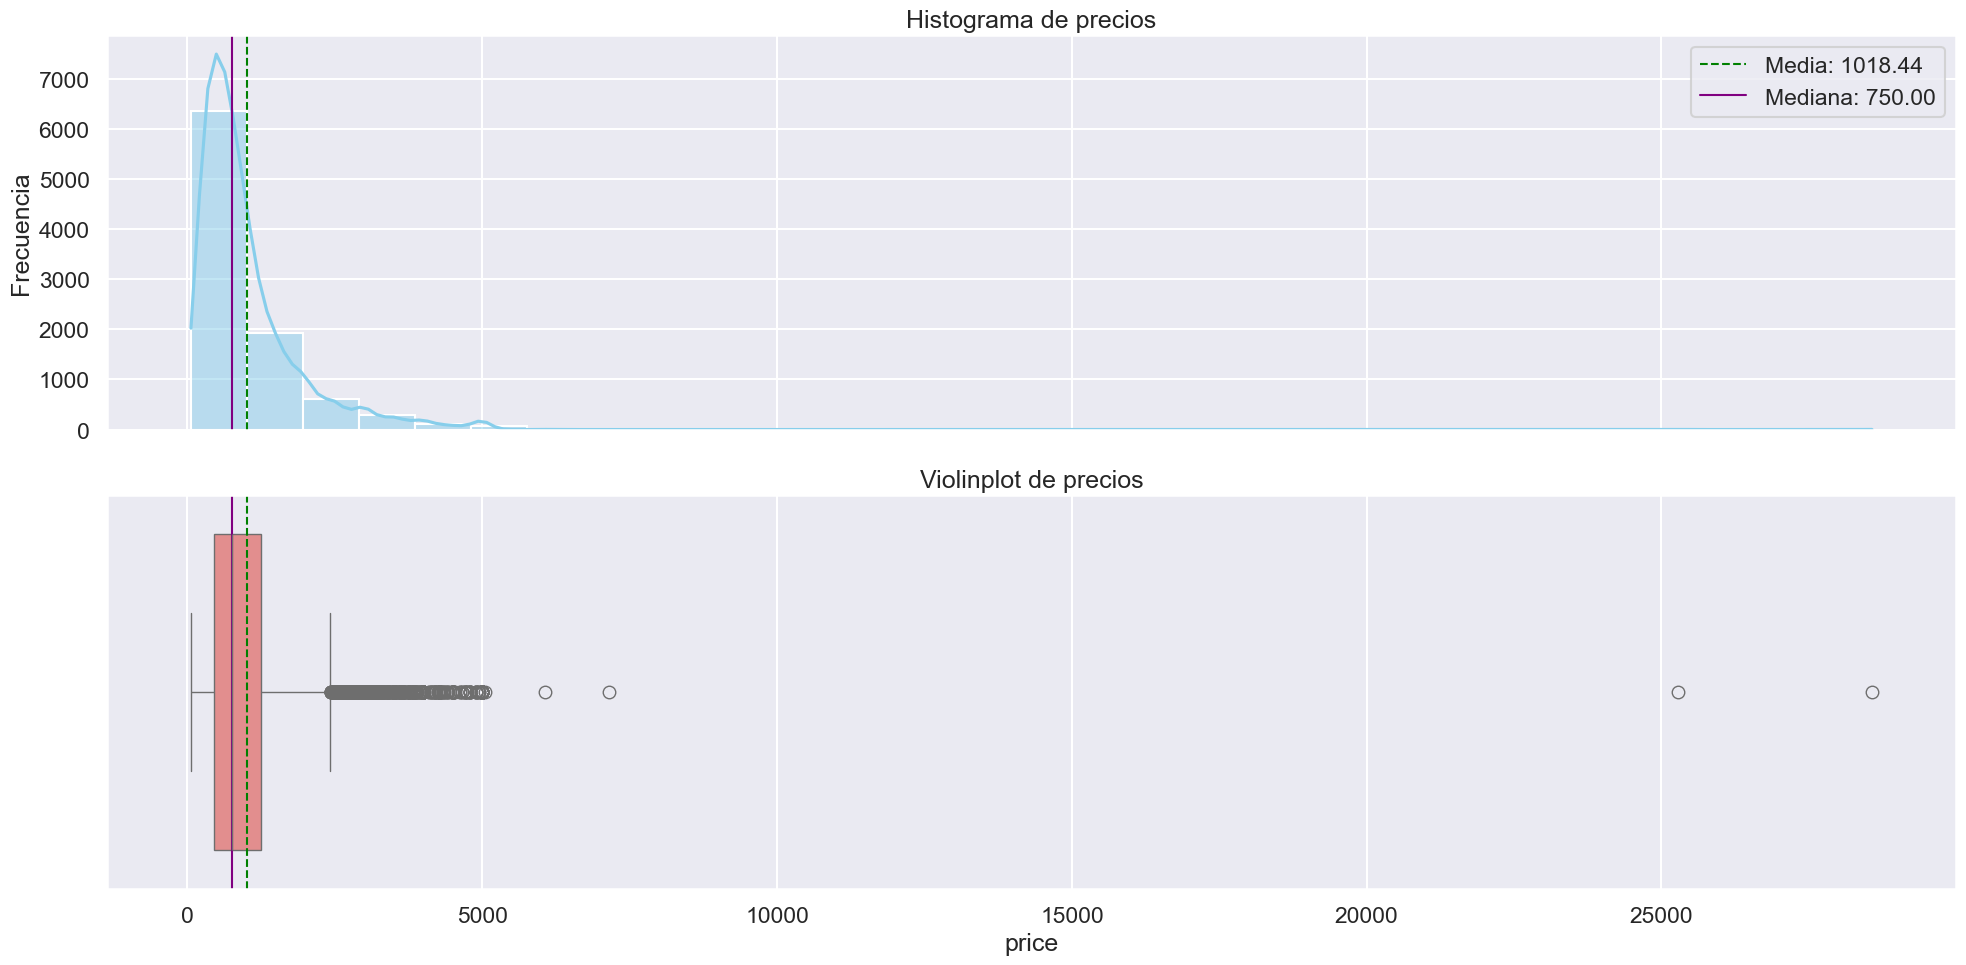

In [17]:
media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

Insights:
* Vemos que la distribuci√≥n es asim√©trica, con una cola larga de outliers a la derecha y con la mayor√≠a de los precios hacia la izquierda. 
* Los outliers son de precios altos, m√°s all√° de 3.000 ‚Ç¨ y hasta 6.000 ‚Ç¨.
* La mediana (750 ‚Ç¨) est√° por debajo de la media (1009,92 ‚Ç¨), lo cual confirma el sesgo positivo.

### Imputaci√≥n
En este contexto, imputar por la media no ser√≠a lo ideal porque se ver√≠a muy influenciada por outliers.   
Por lo que optamos por imputar usando la mediana por ciudad, tipo de habitaci√≥n y accomodates. Esto es simple pero efectivo.

In [18]:
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

In [19]:
print(f'Hay {df["price"].isnull().sum()} precios con valores nulos')

Hay 6 precios con valores nulos


##### Filtramos los registros que siguen teniendo precios con valores nulos, y veremos que combinaciones no se pudieron imputar.

In [20]:
faltantes = df[df['price'].isnull()]

print(faltantes[['city', 'room_type', 'accommodates']].drop_duplicates())

          city        room_type  accommodates
5459  mallorca  Entire home/apt            18
6756    madrid       Hotel room             4
4588   menorca  Entire home/apt            16
3247  mallorca  Entire home/apt            29
6234  mallorca  Entire home/apt            20
7675  mallorca  Entire home/apt            24


In [21]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

La primera ejecucion del c√≥digo resulto en grupos que segu√≠an teniedo valores nulos en 6 registros, por eso agregamos una segunda parte con un grupo m√°s general para estos casos (sin tomar en cuenta los 'accommodates', solo ciudad y tipo de habitacion).

##### Segunda comprobaci√≥n

In [22]:
print(f"Hay {df['price'].isnull().sum()} precios con valores nulos")

Hay 0 precios con valores nulos


# EDA's 

### EDA Operaciones

#### Funciones 

Funci√≥n de generaci√≥n de gr√°ficos EDA Operaciones

In [23]:
def generar_graficos_disponibilidad(df):
    
    # Calcular la media de disponibilidad por ciudad
    disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()

    # Calcular el porcentaje de disponibilidad respecto al total de d√≠as posibles (30, 60, 90, 365)
    disponibilidad_media_porcentaje = disponibilidad_media.copy()

    # Calcular el porcentaje para cada columna de disponibilidad
    disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
    disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
    disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
    disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

    # Definir una paleta de colores coherente y con buen contraste para los gr√°ficos
    colores = sns.color_palette("Set2", 4)  # Usamos una paleta de colores m√°s saturados y contrastantes

    # Mostrar la media de disponibilidad por ciudad
    print("Media de disponibilidad por ciudad\n")
    print(disponibilidad_media)

    # Mostrar la media de disponibilidad en porcentaje por ciudad
    print("\nMedia de disponibilidad en porcentaje por ciudad\n")
    print(disponibilidad_media_porcentaje)

Funcion de distribuci√≥n de la disponibilidad en los distintos per√≠odos boxplot

In [24]:
def distribucion_disponibilidadboxplot(df, colores):
    # Crear la figura y la cuadr√≠cula de subgr√°ficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de per√≠odos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadr√≠cula
        sns.boxplot(data=disponibilidad, color=colores[i], ax=ax[fila, columna])
        
        # A√±adir t√≠tulo y etiquetas
        ax[fila, columna].set_title(f'Distribuci√≥n de la Disponibilidad en los √öltimos {periodo} D√≠as', fontsize=12)
        ax[fila, columna].set_xlabel(f'D√≠as Disponibles (√öltimos {periodo} d√≠as)', fontsize=10)
        ax[fila, columna].set_ylabel('D√≠as Disponibles', fontsize=10)
    
    # Ajustar el dise√±o para una mejor visualizaci√≥n
    plt.tight_layout()
    plt.show()

Funcion de  distribuci√≥n de la disponibilidad en los distintos per√≠odos barras

In [25]:
def distribucion_disponibilidadbarras(df, colores):
    # Crear la figura y la cuadr√≠cula de subgr√°ficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de per√≠odos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadr√≠cula
        sns.histplot(disponibilidad, kde=True, color=colores[i], bins=30, ax=ax[fila, columna])
        
        # A√±adir t√≠tulo y etiquetas
        ax[fila, columna].set_title(f'Distribuci√≥n de la Disponibilidad en los √öltimos {periodo} D√≠as', fontsize=12)
        ax[fila, columna].set_xlabel(f'D√≠as Disponibles (√öltimos {periodo} d√≠as)', fontsize=10)
        ax[fila, columna].set_ylabel('Frecuencia', fontsize=10)
    
    # Ajustar el dise√±o para una mejor visualizaci√≥n
    plt.tight_layout()
    plt.show()

Funcion de mini gr√°ficos para cada categor√≠a de disponibilidad

In [26]:
def mini_graficos_categoria(disponibilidad_media, colores):
    # Segunda parte: Mini gr√°ficos para cada categor√≠a de disponibilidad (sin porcentajes)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas

    # Lista de categor√≠as
    categorias = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

    for i, categoria in enumerate(categorias):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)

        ax_sub = ax[fila, columna]
        # Para cada categor√≠a, mostrar la disponibilidad media sin porcentajes
        disponibilidad_media[categoria].plot(kind='bar', ax=ax_sub, width=0.8, color=colores[i])

        ax_sub.set_title(f'Disponibilidad Media {categoria}', fontsize=12)
        ax_sub.set_xlabel('Ciudad', fontsize=10)
        ax_sub.set_ylabel(f'Media {categoria}', fontsize=10)
        ax_sub.set_xticklabels(disponibilidad_media.index, rotation=45, ha='right')

    # Ajustar el dise√±o para una mejor visualizaci√≥n
    plt.tight_layout()
    plt.show()

Funcion para cada ciudad con disponibilidad media en porcentaje

In [27]:
def graficos_por_ciudad(disponibilidad_media_porcentaje, colores):
    # Tercera parte: Gr√°ficos de barras para cada ciudad con la disponibilidad media en porcentaje
    
    # Determinar el n√∫mero de filas y columnas en la cuadr√≠cula (4x4)
    num_ciudades = len(disponibilidad_media_porcentaje)
    filas = 2
    columnas = 4
    
    # Crear la figura y la cuadr√≠cula de subgr√°ficos
    fig, ax = plt.subplots(filas, columnas, figsize=(20, 10))  # Ajustamos el tama√±o de la figura
    
    # Convertir la matriz de ejes en una lista para poder iterar sobre ella
    ax = ax.flatten()
    
    for i, ciudad in enumerate(disponibilidad_media_porcentaje.index):
        # Extraer los valores de disponibilidad para la ciudad
        ciudad_data = disponibilidad_media_porcentaje.loc[ciudad]

        # Seleccionar el eje correspondiente en la cuadr√≠cula
        ax[i].bar(ciudad_data.index, ciudad_data.values, color=colores, width=0.8)

        # A√±adir t√≠tulo y etiquetas
        ax[i].set_title(f'Disponibilidad Media (%)\npor Ciudad: {ciudad}', fontsize=12)
        ax[i].set_xlabel('Periodo (d√≠as)', fontsize=10)
        ax[i].set_ylabel('Disponibilidad Media (%)', fontsize=10)

        # Ajustar las etiquetas del eje X autom√°ticamente
        ax[i].tick_params(axis='x', rotation=45)

        # Establecer los l√≠mites de los ejes
        ax[i].set_ylim(0, 100)  # Limitar el eje Y de 0 a 100
        ax[i].set_xlim(-0.5, 3.5)  # Limitar el eje X de 0 a 3 (porque tenemos 4 barras)

    # Ajustar el dise√±o para una mejor visualizaci√≥n
    plt.tight_layout()
    plt.show()

Funcion de las medias de todas las ciudades

In [28]:
def grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores):
    # √öltima parte: Gr√°fico de las medias de todas las ciudades
    plt.figure(figsize=(12, 8))
    disponibilidad_media_porcentaje.plot(kind='bar', figsize=(12, 8), color=colores)
    plt.title('Disponibilidad Media (%) de los Alojamientos Tur√≠sticos por Ciudad')
    plt.xlabel('Ciudad')
    plt.ylabel('Disponibilidad Media (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Graficos

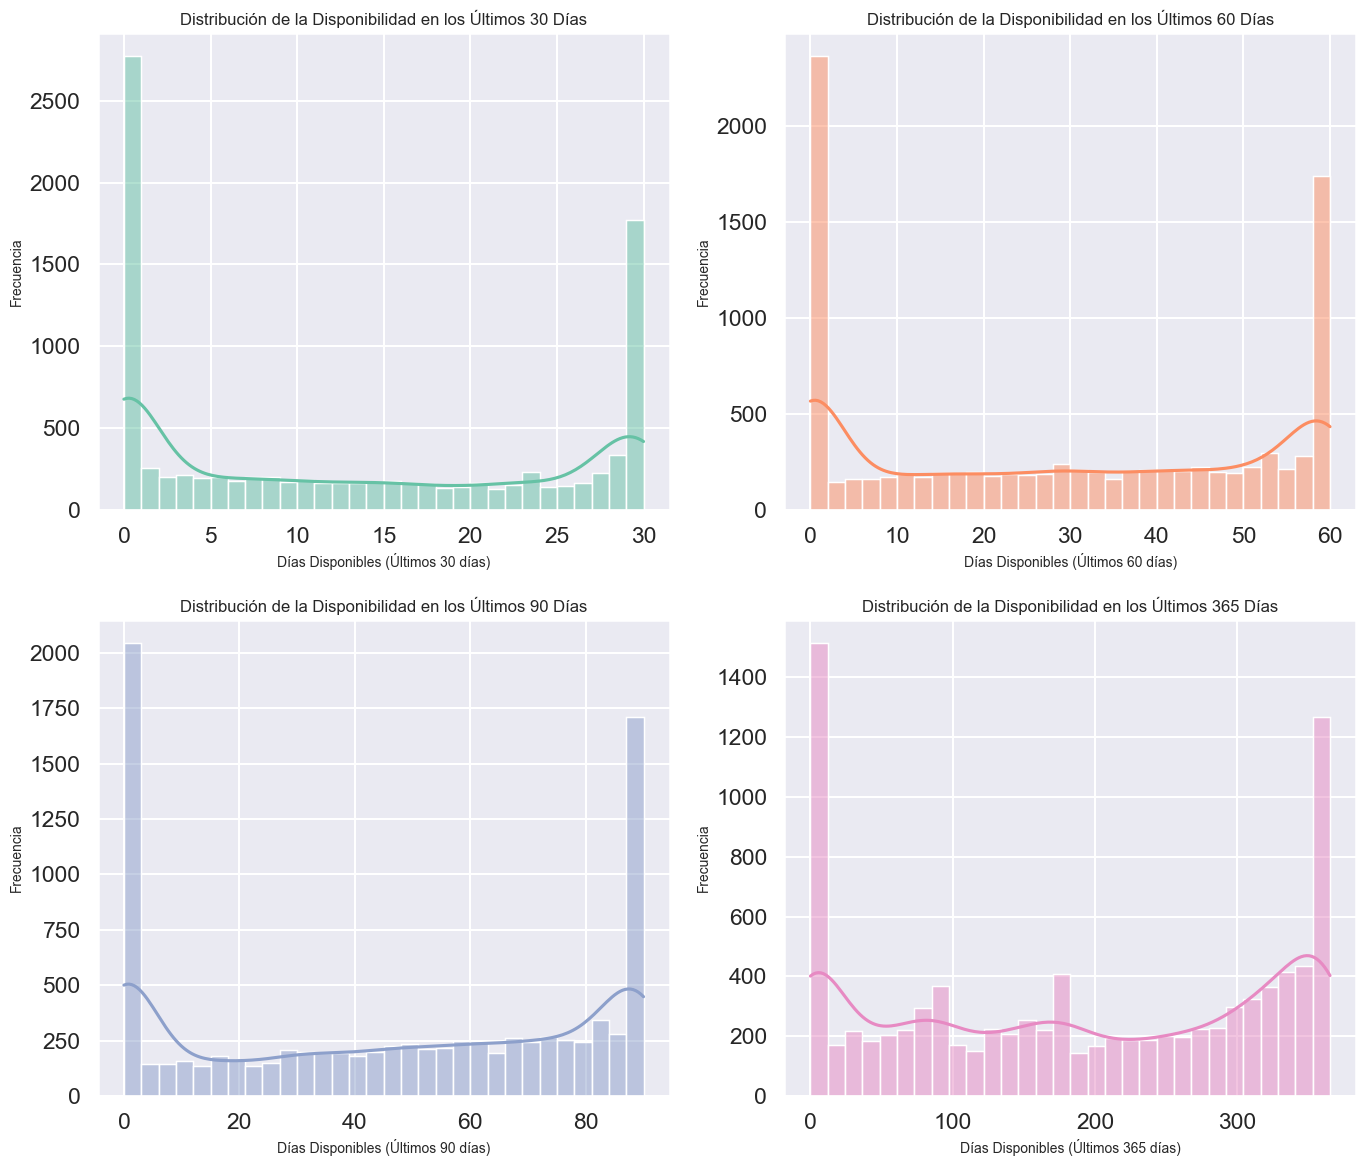

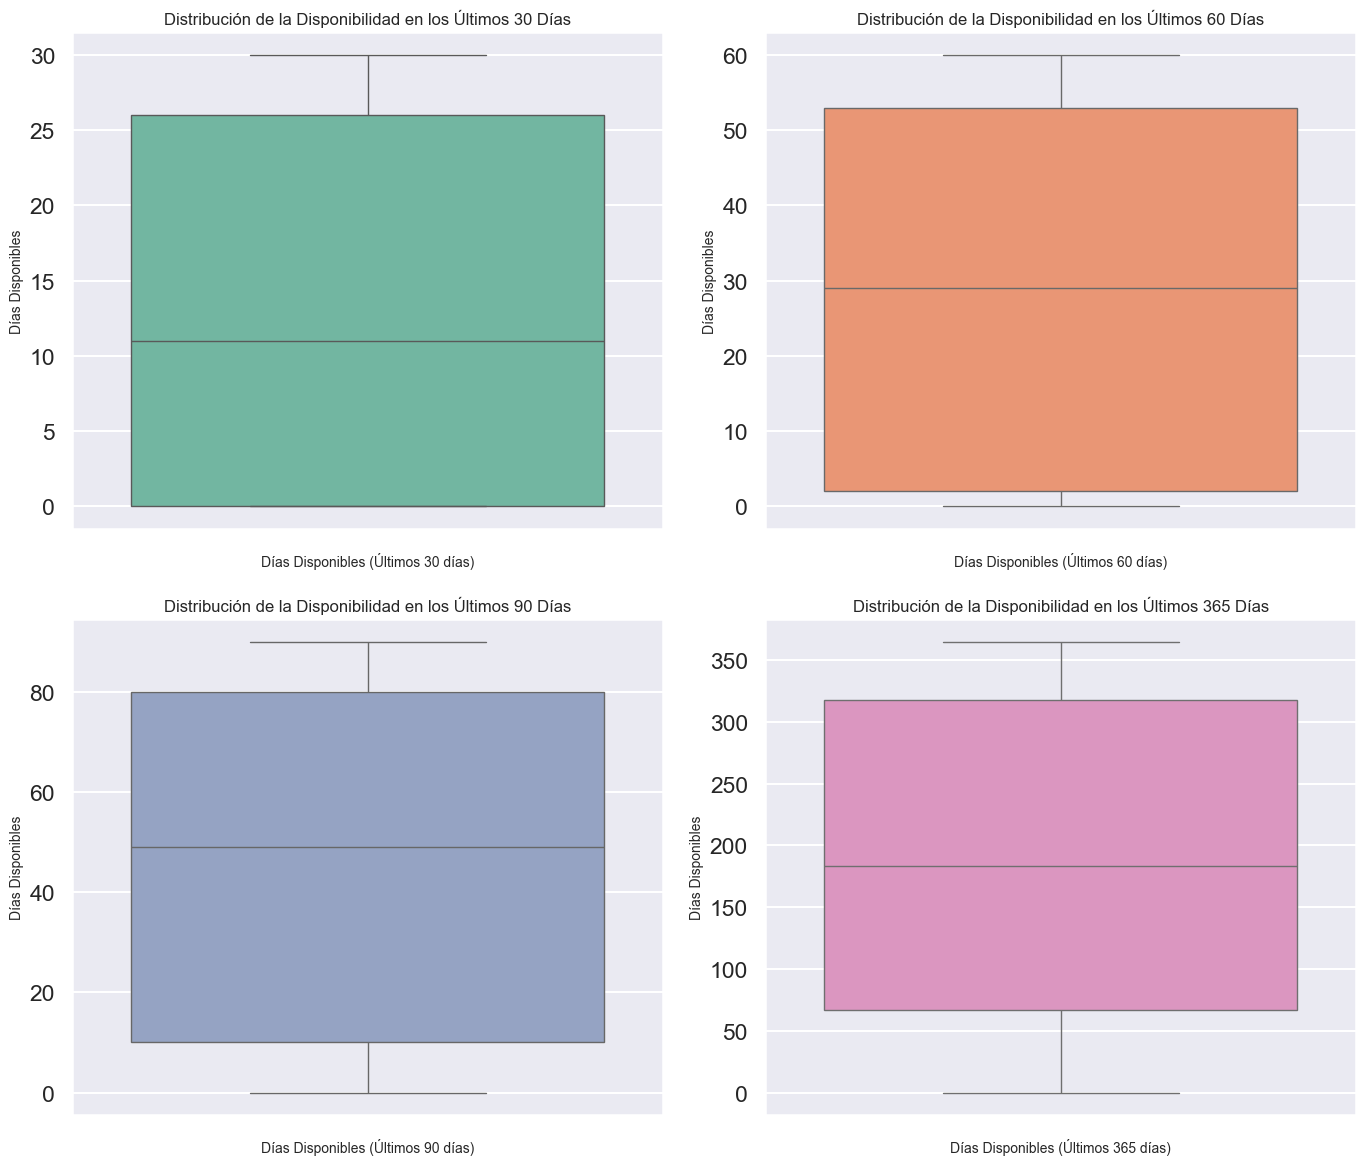

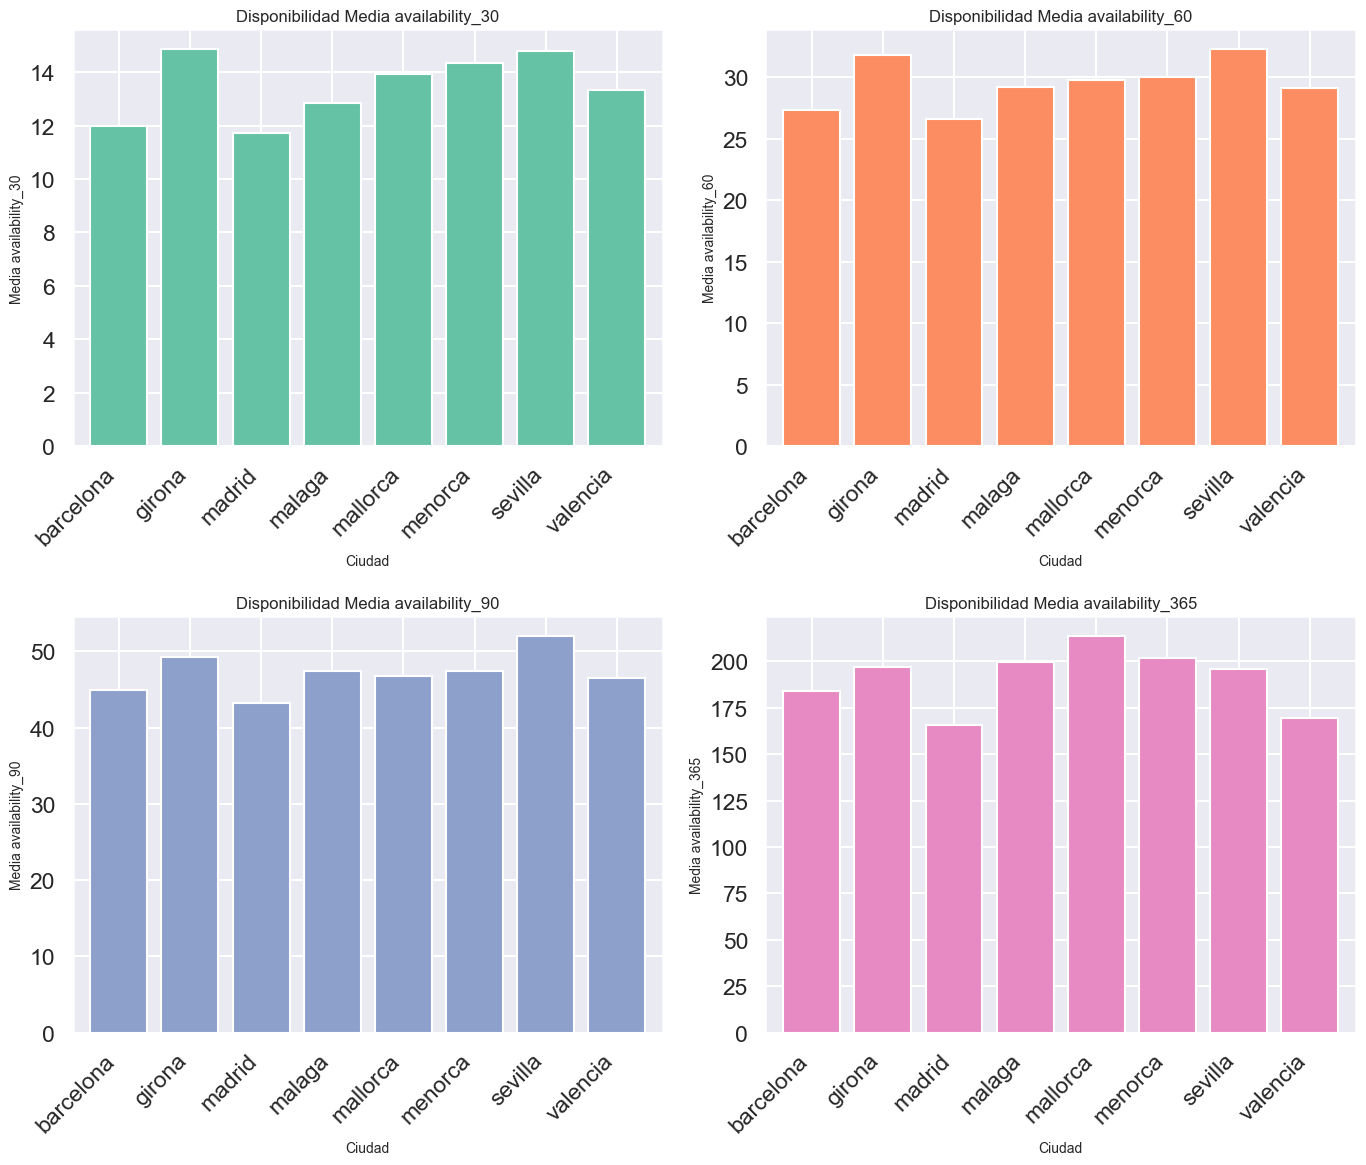

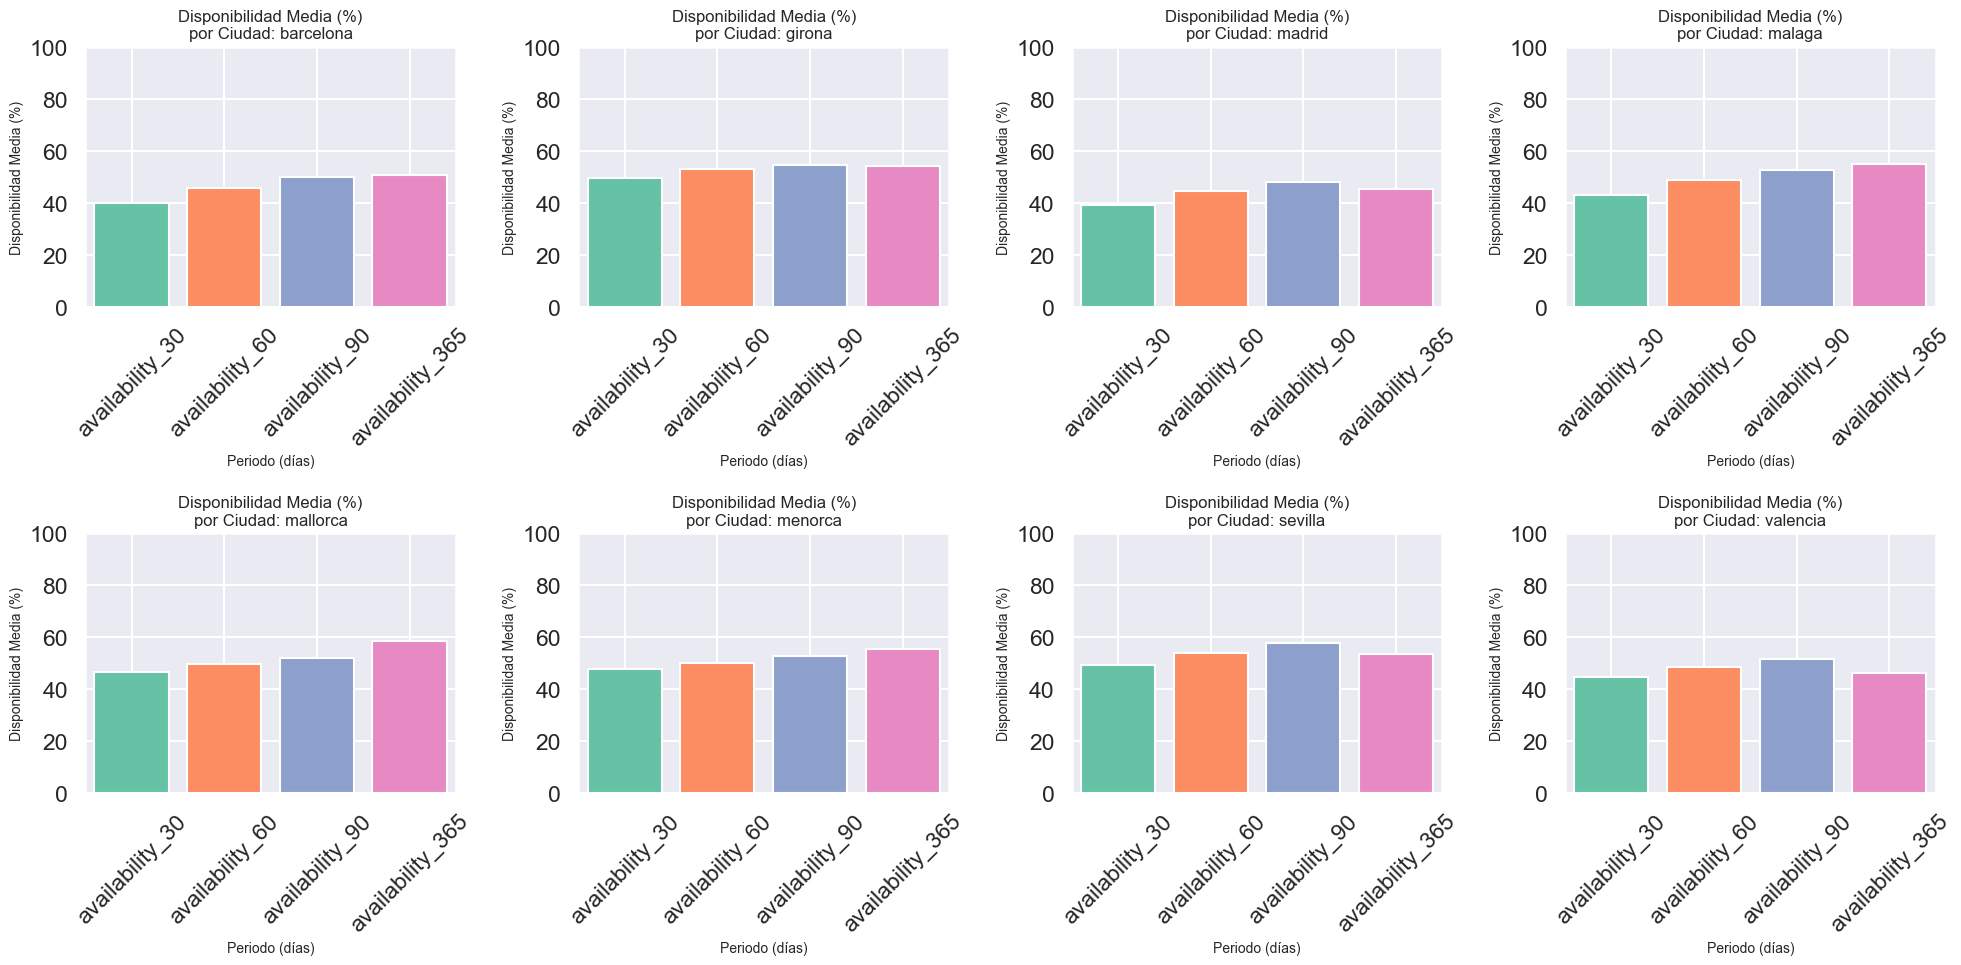

<Figure size 1200x800 with 0 Axes>

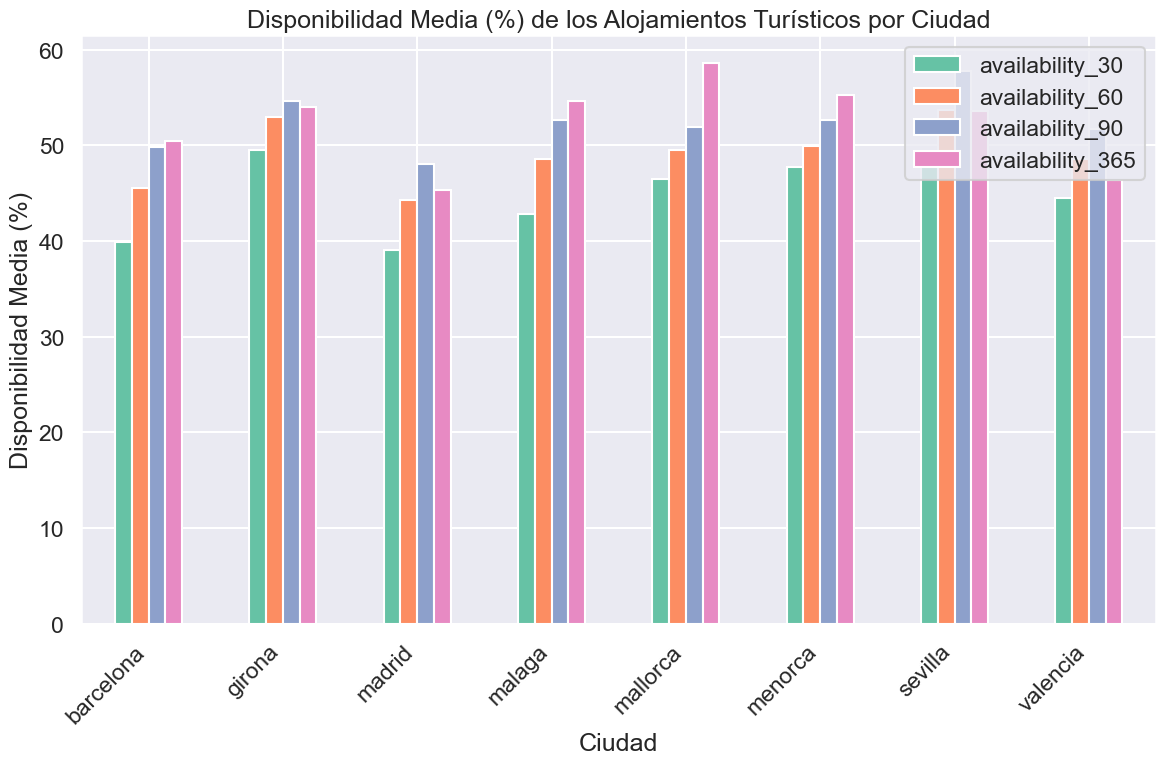

In [29]:
# Primero, calcular los porcentajes y la media
disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()
disponibilidad_media_porcentaje = disponibilidad_media.copy()

# Calcular los porcentajes para cada columna
disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

# Definir la paleta de colores
colores = sns.color_palette("Set2", 4)

# Llamar las funciones para generar los gr√°ficos
distribucion_disponibilidadbarras(df, colores)
distribucion_disponibilidadboxplot(df, colores)
mini_graficos_categoria(disponibilidad_media, colores)
graficos_por_ciudad(disponibilidad_media_porcentaje, colores)
grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores)

### EDA Clientes

#### Analisis descriptivo

In [30]:
df[['apartment_id', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month','city']].describe(include='all')

apartment_id              first_review_date  \
count   9.633000e+03                           7095   
unique           NaN                            NaN   
top              NaN                            NaN   
freq             NaN                            NaN   
mean    2.124478e+07  2017-06-16 02:53:31.839323392   
min     1.196400e+04            2010-01-02 00:00:00   
25%     1.334021e+07            2016-06-17 00:00:00   
50%     2.068392e+07            2017-08-08 00:00:00   
75%     3.019509e+07            2018-09-20 12:00:00   
max     4.806155e+07            2021-01-17 00:00:00   
std     1.161495e+07                            NaN   

                     last_review_date  review_scores_rating  \
count                            7094           6993.000000   
unique                            NaN                   NaN   
top                               NaN                   NaN   
freq                              NaN                   NaN   
mean    2019-01-11 05:55:50.324217856            919.222079   
min               2012-11-17 00:00:00            200.000000   
25%               2018-06-10 06:00:00            890.000000   
50%               2019-04-05 12:00:00            940.000000   
75%               2019-10-29 00:00:00            980.000000   
max               2021-02-21 00:00:00           1000.000000   
std                               NaN             92.496960   

        review_scores_accuracy  review_scores_cleanliness  \
count              6984.000000                6990.000000   
unique                     NaN                        NaN   
top                        NaN                        NaN   
freq                       NaN                        NaN   
mean                 94.501718                  93.137339   
min                  20.000000                  20.000000   
25%                  90.000000                  90.000000   
50%                 100.000000                 100.000000   
75%                 100.000000                 100.000000   
max                 100.000000                 100.000000   
std                   9.474719                  10.079794   

        review_scores_checkin  review_scores_communication  \
count             6979.000000                  6988.000000   
unique                    NaN                          NaN   
top                       NaN                          NaN   
freq                      NaN                          NaN   
mean                96.248746                    96.217802   
min                 20.000000                    20.000000   
25%                 90.000000                    90.000000   
50%                100.000000                   100.000000   
75%                100.000000                   100.000000   
max                100.000000                   100.000000   
std                  8.252189                     8.294843   

        review_scores_location  review_scores_value  reviews_per_month  \
count              6978.000000          6978.000000        7095.000000   
unique                     NaN                  NaN                NaN   
top                        NaN                  NaN                NaN   
freq                       NaN                  NaN                NaN   
mean                 95.429923            91.394382         123.827766   
min                  20.000000            20.000000           1.000000   
25%                  90.000000            90.000000          18.000000   
50%                 100.000000            90.000000          58.000000   
75%                 100.000000           100.000000         177.500000   
max                 100.000000           100.000000        1291.000000   
std                   7.644834             9.964338         153.213229   

             city  
count        9633  
unique          8  
top     barcelona  
freq         2712  
mean          NaN  
min           NaN  
25%           NaN  
50%           NaN  
75%           NaN  
max           NaN  
std

##### Cantidad de apartamentos sin rese√±as

In [31]:
sin_rese√±as = df['first_review_date'].isna().sum()
print(f"N√∫mero de apartamentos sin rese√±as: {sin_rese√±as}")

N√∫mero de apartamentos sin rese√±as: 2538


##### Porcentaje de apartamentos del total


In [32]:
porcentaje_sin_rese√±as = (sin_rese√±as / len(df)) * 100
print(f"Porcentaje de apartamentos sin rese√±as: {porcentaje_sin_rese√±as:.2f} %")

Porcentaje de apartamentos sin rese√±as: 26.35 %


In [33]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = valores_unicos - sin_rese√±as,
    domain = {'x': [0.1, 1], 'y': [0, 1]},
    title = {'text': "Apartamentos con rese√±as"},
    delta = {'reference': valores_unicos},
    gauge = {
        'axis': {'range': [None, valores_unicos]},
        'steps': [
            {'range': [0, valores_unicos - sin_rese√±as], 'color': "white"},
            {'range': [valores_unicos - sin_rese√±as, valores_unicos], 'color': "lightgray"}]}))
fig.update_layout(autosize = False)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
top_apartamentos_puntos = df.sort_values(['review_scores_rating', 'number_of_reviews'], ascending=False)
top_apartamentos_puntos.head(10)

apartment_id                                               name  \
2218      11989301                             Vivienda San MartÔøΩn II   
1783       9122183                 Casa sevillana en barrio historico   
5759      22979863  Stylish Apt PZA MAYOR/La Latina 2BD* 2BT*, 6p max   
6072      23782265  Romantic and Rustic Penthouse with a Sun Kisse...   
5587      22479174                     Private room in detached house   
3365      16292600                                         BCN Luxury   
309        1073748                MAGIC PLACE IN BARCELONA, WITH POOL   
3717      17384311                 Cubic House Garden, Cala Morlanda.   
5404      21916433                Typical majorcan house in Llucmajor   
5408      21925668  ÔøΩtico con piscina Triana 2mm del Centro de sev...   

                                            description    host_id  \
2218  RelÔøΩjate y desconecta mientras la cÔøΩlida luz v...   34840363   
1783  HabitaciÔøΩn luminosa con terraza privada para u...   47528412   
5759  Cozy and well-designed 2 bedroom apartment, co...   29281033   
6072  Marvel at an adorable cottage-like space in an...   40929334   
5587  Cozy private room in a detached villa, near Ad...   80975261   
3365  Lujoso apartamento en pleno centro de Barcelon...   15944590   
309   <b>The space</b><br />MAGIC PLACE IN BARCELONA...    5159312   
3717  Cozy designer apartment located  in a nice gar...   11087082   
5404  Cozy 2 floors family house with 5 double bedro...  159911693   
5408  Nous sommes ÔøΩ Triana ÔøΩ 2mm du centre de Sevill...   15589434   

                         neighbourhood_name neighbourhood_district  \
2218                          SANT FRANCESC           CIUTAT VELLA   
1783                                Pio XII               Macarena   
5759                                Palacio                 Centro   
6072                            ARRANCAPINS              EXTRAMURS   
5587                                  Rejas  San Blas - Canillejas   
3365        l'Antiga Esquerra de l'Eixample               Eixample   
309   Vallvidrera, el Tibidabo i les Planes    SarriÔøΩ-Sant Gervasi   
3717                                Manacor                    NaN   
5404                              Llucmajor                    NaN   
5408                   Triana Casco Antiguo                 Triana   

            room_type  accommodates  bathrooms  bedrooms  ...  \
2218  Entire home/apt             4        1.0       1.0  ...   
1783     Private room             2        2.0       1.0  ...   
5759  Entire home/apt             6        2.0       2.0  ...   
6072  Entire home/apt             2        1.0       1.0  ...   
5587     Private room             2        2.0       1.0  ...   
3365  Entire home/apt             4        2.0       2.0  ...   
309   Entire home/apt             4        1.0       1.0  ...   
3717  Entire home/apt             3        1.0       1.0  ...   
5404  Entire home/apt            10        3.0       5.0  ...   
5408  Entire home/apt             7        2.0       3.0  ...   

      review_scores_checkin review_scores_communication  \
2218                  100.0                       100.0   
1783                  100.0                       100.0   
5759                  100.0                       100.0   
6072                  100.0                       100.0   
5587                  100.0                       100.0   
3365                  100.0                       100.0   
309                   100.0                       100.0   
3717                  100.0                       100.0   
5404                  100.0                       100.0   
5408                  100.0                       100.0   

      review_scores_location  review_scores_value  is_instant_bookable  \
2218                   100.0                100.0            VERDADERO   
1783                    90.0                100.0                FALSO   
5759                   100.0                100.0       

In [ ]:
top_apartamentos_num_reviews = df.sort_values(['number_of_reviews', 'review_scores_rating'], ascending=False)
top_apartamentos_num_reviews.head(10)

apartment_id                                               name  \
63          384727                 Private Room  in Center of Seville   
264         959840                     PL REAL (Sq) PENTHOUSE Rooftop   
511        1871218                     ÔøΩtico apartamento VFT/SE/00804   
729        3058631                      Private Studio in Sol, Madrid   
98          526513                  Sol.  Your home in MadridÔøΩs Heart   
753        3143400                 Great room in the center of Madrid   
145         681925  Very Central, Stunning Views, Sunny Terrace, W...   
478        1670427                Walk everywhere!Brand new apartWIFI   
936        4028518                   Renovated & Vintage en Barcelona   
1313       6289283                       Cozy apartment near El Raval   

                                            description   host_id  \
63    located in the centre of Seville, offers accom...   1920069   
264   Rustic penthous with old beams,old ceramic flo...   5223863   
511   ÔøΩtico muy luminoso. Consta de: SalÔøΩn, BaÔøΩo, Co...   9751847   
729   We are offering a clean, well presented and re...  14370747   
98    DESIGN apartment in the HEART of Madrid.<br />...   1134989   
753   Bright room in hortaleza Street, next to Gran ...  15328893   
145   FANTASTIC PENTHOUSE LOCATED IN THE CENTER OF V...   3462415   
478   The apartment is  right in the center of Barce...   8843962   
936   Welcome to this cozy apartment located in the ...  20886062   
1313  Nice bright room with large private terrace (p...  32695481   

           neighbourhood_name neighbourhood_district        room_type  \
63                     Arenal          Casco Antiguo     Private room   
264            el Barri GÔøΩtic           Ciutat Vella     Private room   
511   LeÔøΩn XIII, Los Naranjos               Macarena  Entire home/apt   
729                       Sol                 Centro  Entire home/apt   
98                        Sol                 Centro  Entire home/apt   
753                  Justicia                 Centro     Private room   
145                  EL PILAR           CIUTAT VELLA  Entire home/apt   
478    la Dreta de l'Eixample               Eixample  Entire home/apt   
936        la Sagrada FamÔøΩlia               Eixample  Entire home/apt   
1313                 el Raval           Ciutat Vella     Private room   

      accommodates  bathrooms  bedrooms  ...  review_scores_checkin  \
63               2        1.0       1.0  ...                  100.0   
264              2        2.0       1.0  ...                  100.0   
511              2        1.0       1.0  ...                  100.0   
729              3        1.0       1.0  ...                  100.0   
98               5        1.0       2.0  ...                  100.0   
753              2        1.0       1.0  ...                  100.0   
145              2        1.0       1.0  ...                  100.0   
478              5        1.0       1.0  ...                  100.0   
936              4        1.0       2.0  ...                  100.0   
1313             2        1.0       1.0  ...                  100.0   

     review_scores_communication  review_scores_location  review_scores_value  \
63                         100.0                   100.0                100.0   
264                        100.0                   100.0                100.0   
511                        100.0                    90.0                 80.0   
729                        100.0                   100.0                 90.0   
98                         100.0                   100.0                100.0   
753                        100.0                   100.0                100.0   
145                        100.0                   100.0                100.0   
478                        100.0                   100.0                 90.0   
936                        100.0                   100.0                100.0   
1313                        90

#### Imputar fecha de inserci√≥n del registro para los casos en que hay rese√±as y la last_review_date es nula


In [ ]:
df.loc[df['last_review_date'].isna() & df['first_review_date'].notna(), 'last_review_date'] = df['insert_date']

#### Graficos

##### Distribuci√≥n de n√∫meros de reviews

Text(0.5, 0, 'N.¬∫ de rese√±as')

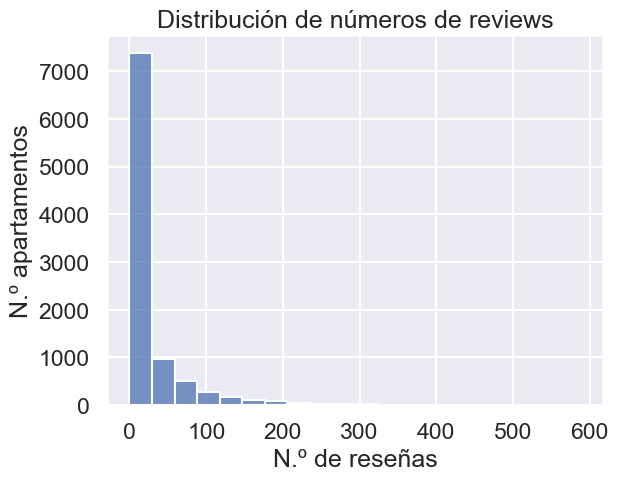

In [ ]:
ax = sns.histplot(data=df, x='number_of_reviews', bins=20)
ax.set_title("Distribuci√≥n de n√∫meros de reviews")
ax.set_ylabel("N.¬∫ apartamentos")
ax.set_xlabel("N.¬∫ de rese√±as")

##### Kde de distribuci√≥n de reviews

Text(0.5, 0.98, 'Kde de distribuci√≥n de reviews')

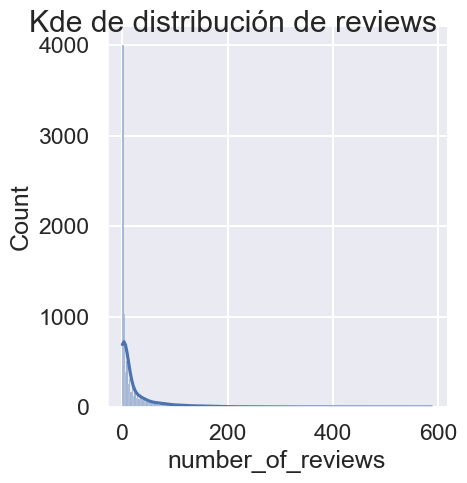

In [ ]:
ax = sns.displot(data=df, x='number_of_reviews', kde=True)
ax.figure.suptitle("Kde de distribuci√≥n de reviews")

##### Distribuci√≥n estad√≠stica del rating total por ciudad

Text(0.5, 1.0, 'Distribuci√≥n estad√≠stica del rating total por ciudad')

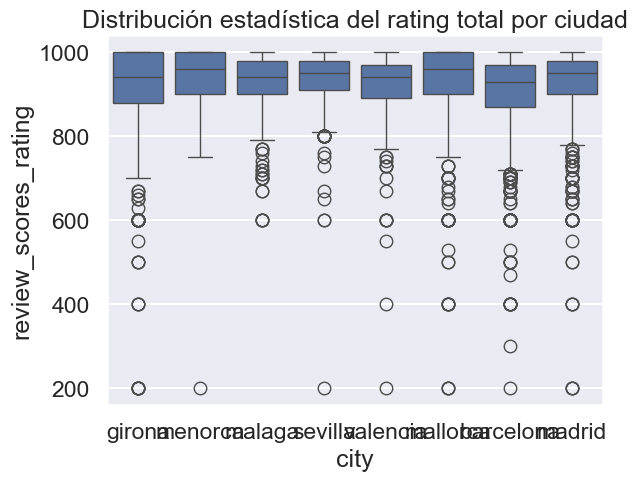

In [ ]:
ax = sns.boxplot(data=df, x='city', y='review_scores_rating')
ax.set_title("Distribuci√≥n estad√≠stica del rating total por ciudad")

##### Distribuci√≥n estad√≠stica del rating total por tipo de alojamiento

Text(0.5, 1.0, 'Distribuci√≥n estad√≠stica del rating total por tipo de alojamiento')

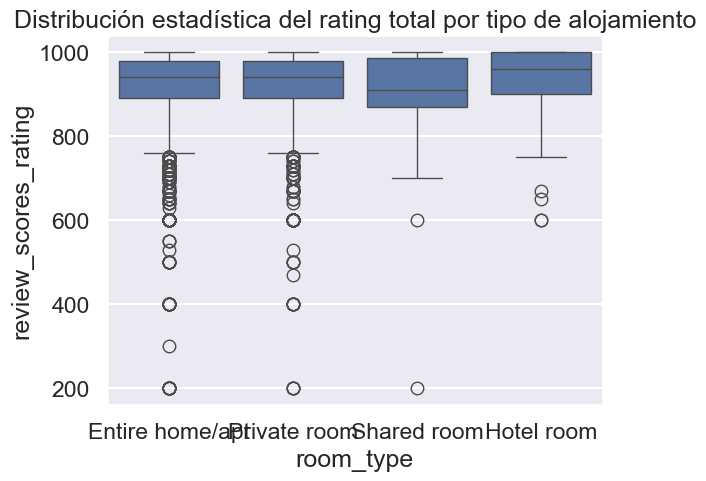

In [ ]:
ax = sns.boxplot(data=df, x='room_type', y='review_scores_rating')
ax.set_title("Distribuci√≥n estad√≠stica del rating total por tipo de alojamiento")

#### Frecuencia de rese√±as al mes por puntuaci√≥n

<Axes: xlabel='review_scores_value', ylabel='reviews_per_month'>

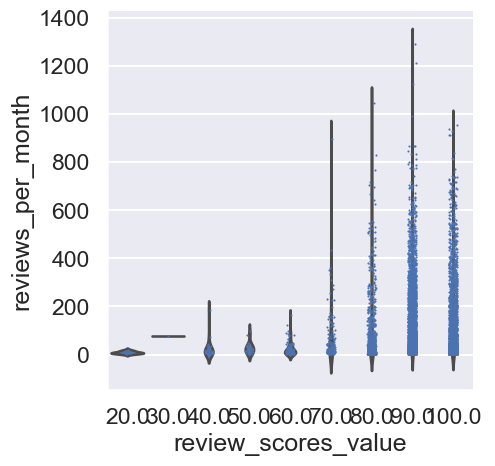

In [ ]:
g = sns.catplot(data=df, x='review_scores_value', y='reviews_per_month', kind="violin", inner=None)
sns.stripplot(data=df, x='review_scores_value', y='reviews_per_month', color="b", size=1.5, ax=g.ax)

### EDA Marketing y comunicacion

#### Funciones


##### Funci√≥n para a√±adir el s√≠mbolo ‚Ç¨ a los valores del eje

In [ ]:
def euro_formatter(x, pos):
    return f"{x:,.0f}‚Ç¨"  # Format amb 0 

##### Funci√≥n para formatear el eje y con separador de miles

In [ ]:
def formato_miles(x, pos):
    return f'{int(x):,}'

##### Establecer paleta y estilo

In [ ]:
sns.set_style("darkgrid")
sns.set_palette("tab10") 

#### Analisis Descriptivo

##### Variables numericas

In [ ]:
print(df.describe()) 

       apartment_id       host_id  accommodates    bathrooms     bedrooms  \
count  9.633000e+03  9.633000e+03   9633.000000  9567.000000  9566.000000   
mean   2.124478e+07  9.107818e+07      4.268245     1.593185     1.937173   
min    1.196400e+04  1.070400e+04      1.000000     0.000000     0.000000   
25%    1.334021e+07  1.512449e+07      2.000000     1.000000     1.000000   
50%    2.068392e+07  6.569780e+07      4.000000     1.000000     2.000000   
75%    3.019509e+07  1.429782e+08      6.000000     2.000000     3.000000   
max    4.806155e+07  3.874783e+08     29.000000    13.000000    50.000000   
std    1.161495e+07  8.720254e+07      2.587081     0.988364     1.376801   

              beds         price  minimum_nights  maximum_nights  \
count  9588.000000   9633.000000     9633.000000     9633.000000   
mean      2.923133   1035.464653        4.969480      758.946849   
min       0.000000     60.000000        1.000000        1.000000   
25%       1.000000    450.000000  

##### Tipos de datos y variables nulas

In [ ]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 9633 entries, 3092 to 2456
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9633 non-null   int64         
 1   name                         9630 non-null   object        
 2   description                  9497 non-null   object        
 3   host_id                      9633 non-null   int64         
 4   neighbourhood_name           9633 non-null   object        
 5   neighbourhood_district       5849 non-null   object        
 6   room_type                    9633 non-null   object        
 7   accommodates                 9633 non-null   int64         
 8   bathrooms                    9567 non-null   float64       
 9   bedrooms                     9566 non-null   float64       
 10  beds                         9588 non-null   float64       
 11  amenities_list               9633 non-null   

#### Distribucion de precios

##### General

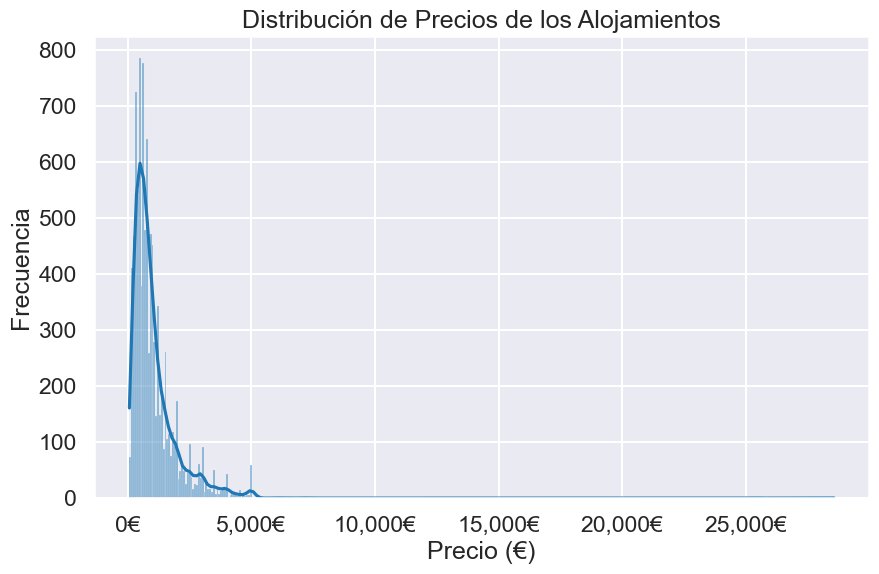

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True) #, color='blue')
plt.title('Distribuci√≥n de Precios de los Alojamientos')
plt.xlabel('Precio (‚Ç¨)')
plt.ylabel('Frecuencia')
# Aplicar el formatter al eje X para mostrar el s√≠mbolo ‚Ç¨
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por ciudad

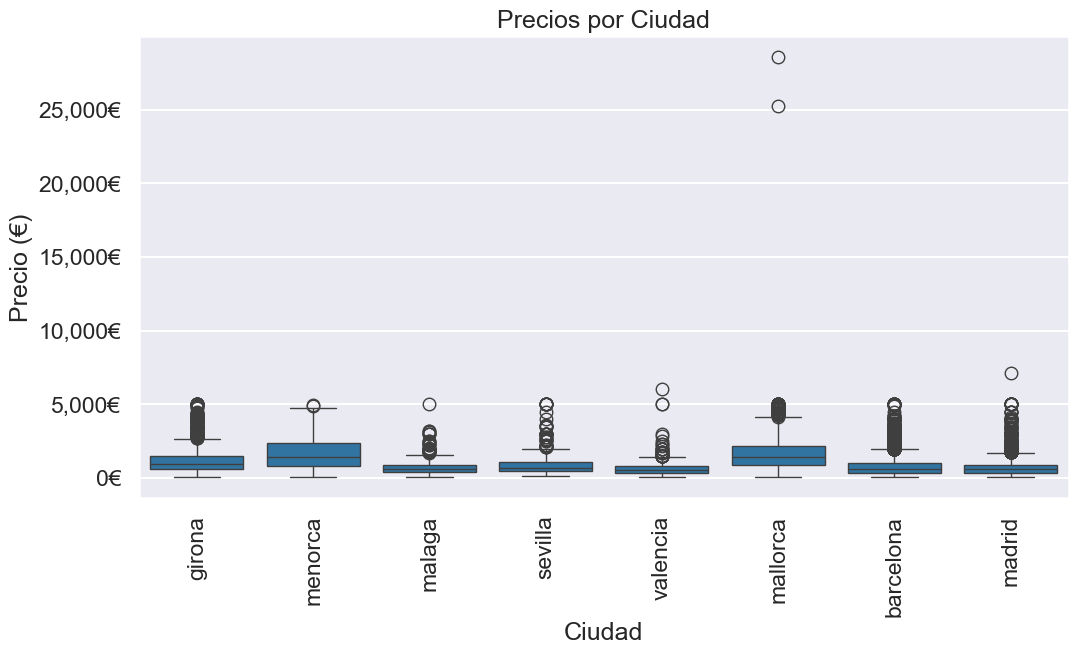

In [ ]:
# Boxplot de precios por ciudad
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df)
plt.title('Precios por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Precio (‚Ç¨)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.xticks(rotation=90)
plt.show()

##### Precios por tipo de alojamiento

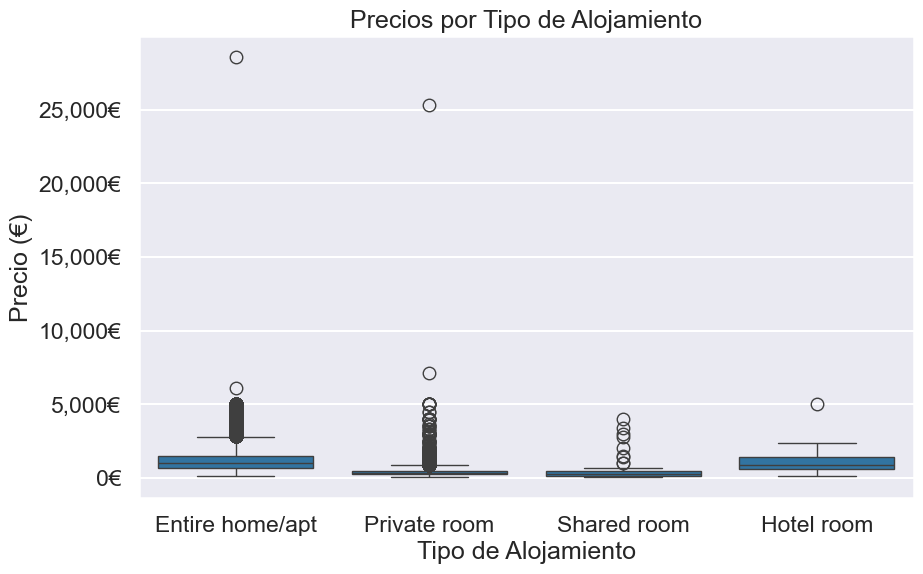

In [ ]:
# Boxplot de precios por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precios por Tipo de Alojamiento')
plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Precio (‚Ç¨)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numeros de cama

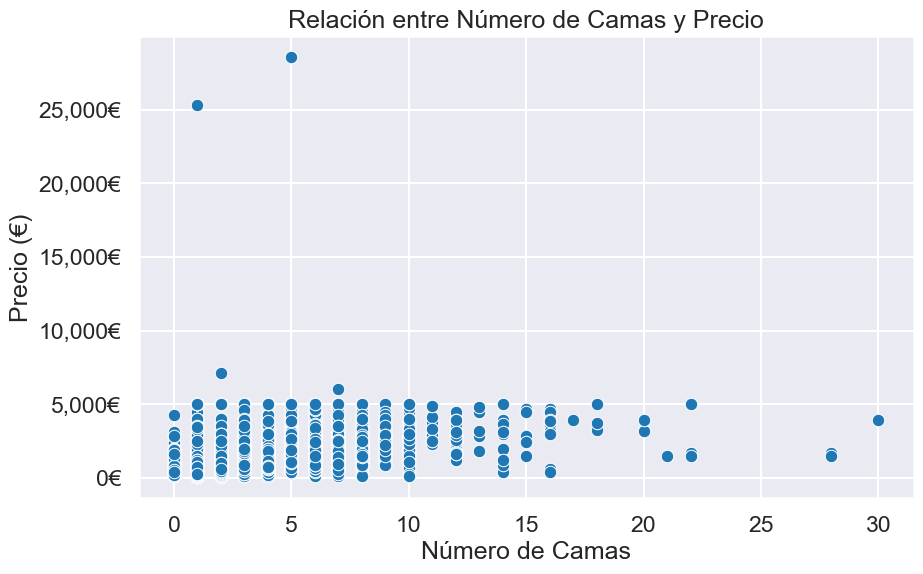

In [ ]:
# Relaci√≥n entre el n√∫mero de camas y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='beds', y='price', data=df)
plt.title('Relaci√≥n entre N√∫mero de Camas y Precio')
plt.xlabel('N√∫mero de Camas')
plt.ylabel('Precio (‚Ç¨)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numero de habitaciones

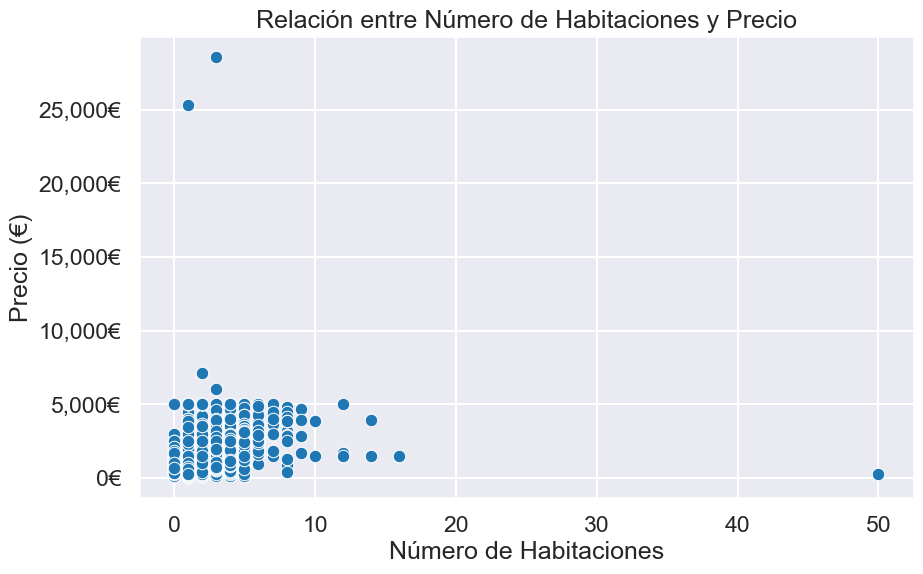

In [ ]:
# Relaci√≥n entre el n√∫mero de habitaciones y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.title('Relaci√≥n entre N√∫mero de Habitaciones y Precio')
plt.xlabel('N√∫mero de Habitaciones')
plt.ylabel('Precio (‚Ç¨)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

#### Reserva instantanea y Distribucion

##### Porcentaje de alojamiento con reserva instantanea

In [ ]:
instant_bookable_percentage = df['is_instant_bookable'].value_counts(normalize=True) * 100
print(instant_bookable_percentage)

is_instant_bookable
VERDADERO    58.040071
FALSO        41.959929
Name: proportion, dtype: float64


##### Distribuci√≥n de alojamientos con reserva instant√°nea

C:\Users\diego\AppData\Local\Temp\ipykernel_14504\1596701451.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




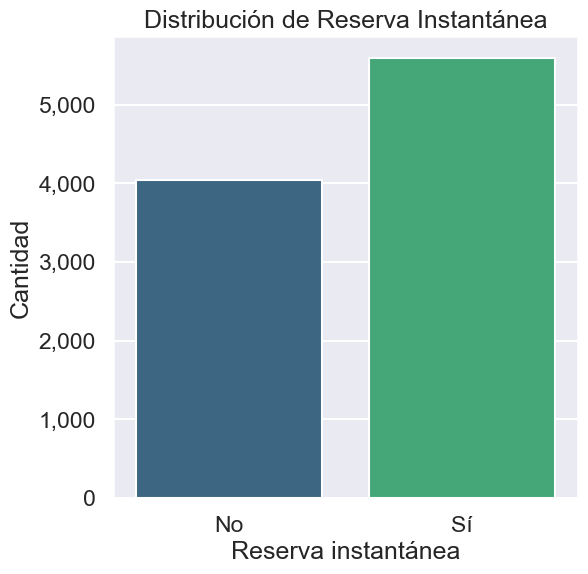

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(x='is_instant_bookable', data=df, palette='viridis')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Reserva instant√°nea')
plt.ylabel('Cantidad')
plt.title('Distribuci√≥n de Reserva Instant√°nea')
plt.xticks([0, 1], ['No', 'S√≠'])
plt.show()

#### Analisis de rese√±as

##### Numero de rese√±as y puntuaciones

Rese√±as

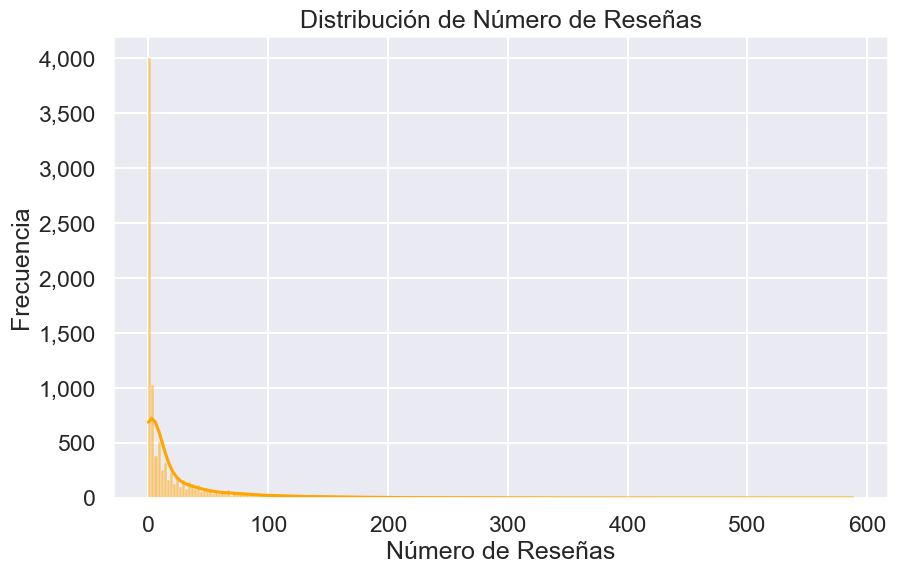

In [ ]:
# Histograma de n√∫mero de rese√±as
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_reviews'], kde=True, color='orange')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribuci√≥n de N√∫mero de Rese√±as')
plt.xlabel('N√∫mero de Rese√±as')
plt.ylabel('Frecuencia')
plt.show()

Puntuaciones

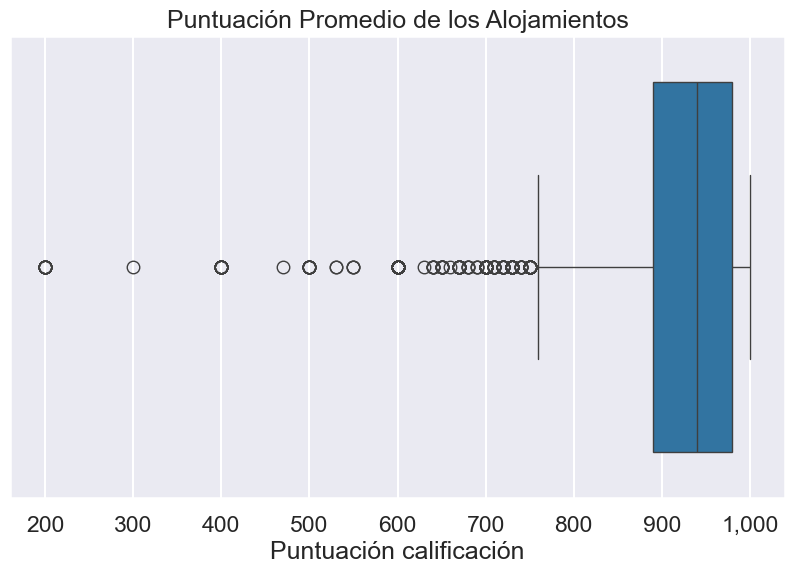

In [ ]:
 # Boxplot de puntuaciones
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_scores_rating', data=df)

plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Puntuaci√≥n calificaci√≥n')
plt.title('Puntuaci√≥n Promedio de los Alojamientos')
plt.show()

##### Puntuaciones por tipo de alojamiento

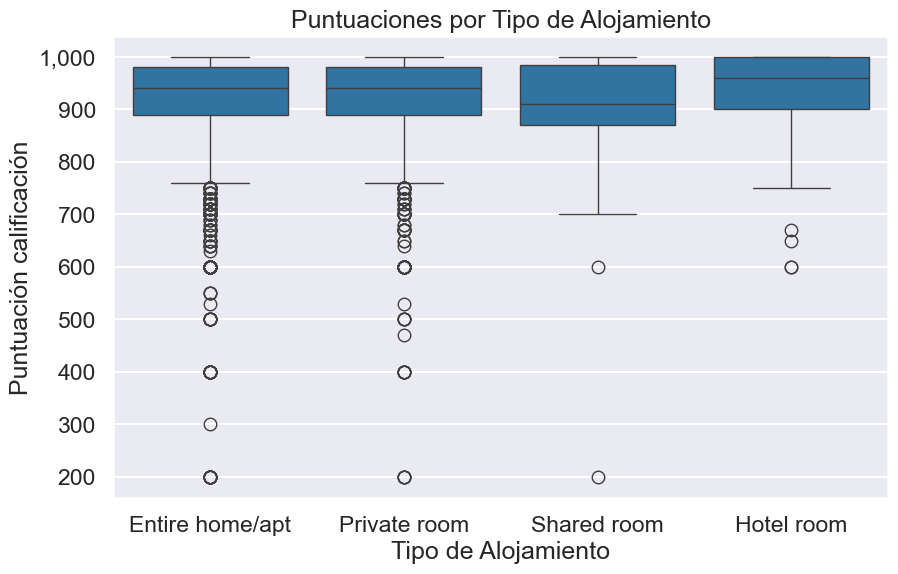

In [ ]:
# Boxplot de puntuaciones por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='review_scores_rating', data=df)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Puntuaci√≥n calificaci√≥n')
plt.title('Puntuaciones por Tipo de Alojamiento')
plt.show()

# KPIs

## KPI 1 - Tasa de ocupaci√≥n mensual

### Tasa de ocupacion mensual general

In [ ]:
# Suponiendo que 'availability_30' es el n√∫mero de d√≠as disponibles en los √∫ltimos 30 d√≠as

# Calcular el n√∫mero de d√≠as ocupados
df['days_occupied'] = 30 - df['availability_30']  # Si 'availability_30' tiene los d√≠as disponibles, restamos a 30

# Calcular la tasa de ocupaci√≥n mensual
df['occupancy_rate'] = (df['days_occupied'] / 30) * 100  # Tasa de ocupaci√≥n en porcentaje

# Mostrar las primeras filas con el KPI calculado
df[['apartment_id', 'city', 'room_type', 'availability_30', 'days_occupied', 'occupancy_rate']]

apartment_id       city        room_type  availability_30  \
3092      15248525     girona  Entire home/apt               30   
9896      44391173     girona     Private room               30   
7927      32088176     girona  Entire home/apt                0   
9966      45803831    menorca  Entire home/apt                1   
9857      43993521     girona  Entire home/apt               27   
...            ...        ...              ...              ...   
2635      13707226  barcelona     Private room               30   
3197      15713525  barcelona     Private room                0   
102         544995  barcelona  Entire home/apt               30   
405        1346199  barcelona  Entire home/apt               30   
2456      13166575  barcelona  Entire home/apt               30   

      days_occupied  occupancy_rate  
3092              0        0.000000  
9896              0        0.000000  
7927             30      100.000000  
9966             29       96.666667  
9857              3       10.000000  
...             ...             ...  
2635              0        0.000000  
3197             30      100.000000  
102               0        0.000000  
405               0        0.000000  
2456              0        0.000000  

[9633 rows x 6 columns]

In [ ]:
# Calcular el total de d√≠as ocupados y el total de d√≠as analizados
total_days_occupied = df['days_occupied'].sum()
total_days_analyzed = len(df) * 30  # 30 d√≠as por cada propiedad

# Calcular la tasa de ocupaci√≥n general
general_occupancy_rate = (total_days_occupied / total_days_analyzed) * 100

# Mostrar el resultado
print(f"La tasa de ocupaci√≥n general final es: {general_occupancy_rate:.2f}%")

La tasa de ocupaci√≥n general final es: 56.64%


In [ ]:
fig = go.Figure(go.Indicator(
    mode = "number+gauge+delta",
    gauge = {'shape': "bullet", 
             'axis': {'visible': False}},
    delta = {'reference': 59.24,
             'valueformat': '.2f',
             'suffix' : '%'}, 
    value = general_occupancy_rate,
    domain = {'x': [0.2, 1], 'y': [0.2, 0.9]},
    title = {'text': "Puntuaci√≥n media general",
             'align': 'right'},
    number = {'valueformat': '.2f',
             'suffix' : '%'}
    ))

fig.show()

In [ ]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupaci√≥n promedio
kpi_occupancy = df.groupby(['city'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

        city occupancy_rate
0  barcelona         60.06%
1     girona         50.47%
2     madrid         60.88%
3     malaga         57.21%
4   mallorca         53.52%
5    menorca         52.23%
6    sevilla         50.74%
7   valencia         55.50%


### KPI 1 - Tasa de ocupaci√≥n por tipo de alojamiento:
    KPI de ocupaci√≥n promedio por ciudad y tipo de alojamiento.

In [ ]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupaci√≥n promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         61.89%
1   barcelona       Hotel room         61.75%
2   barcelona     Private room         58.99%
3   barcelona      Shared room         33.33%
4      girona  Entire home/apt         51.00%
5      girona       Hotel room         50.91%
6      girona     Private room         41.95%
7      girona      Shared room          0.00%
8      madrid  Entire home/apt         61.14%
9      madrid       Hotel room         51.19%
10     madrid     Private room         61.33%
11     madrid      Shared room         42.11%
12     malaga  Entire home/apt         57.09%
13     malaga       Hotel room         30.00%
14     malaga     Private room         58.30%
15     malaga      Shared room         76.67%
16   mallorca  Entire home/apt         53.82%
17   mallorca       Hotel room         72.75%
18   mallorca     Private room         48.39%
19   mallorca      Shared room         57.50%
20    menorca  Entire home/apt    

### KPI 1 - Tasa de ocupaci√≥n agrupada por ciudad y tipo de alojamiento en %

In [ ]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupaci√≥n promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         61.89%
1   barcelona       Hotel room         61.75%
2   barcelona     Private room         58.99%
3   barcelona      Shared room         33.33%
4      girona  Entire home/apt         51.00%
5      girona       Hotel room         50.91%
6      girona     Private room         41.95%
7      girona      Shared room          0.00%
8      madrid  Entire home/apt         61.14%
9      madrid       Hotel room         51.19%
10     madrid     Private room         61.33%
11     madrid      Shared room         42.11%
12     malaga  Entire home/apt         57.09%
13     malaga       Hotel room         30.00%
14     malaga     Private room         58.30%
15     malaga      Shared room         76.67%
16   mallorca  Entire home/apt         53.82%
17   mallorca       Hotel room         72.75%
18   mallorca     Private room         48.39%
19   mallorca      Shared room         57.50%
20    menorca  Entire home/apt    

### KPI 1 - Matriz Tasa de ocupaci√≥n por ciudad y tipo de alojamientos en %

In [ ]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupaci√≥n promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Convertir el dataframe a una matriz con las ciudades como filas y los tipos de alojamiento como columnas
occupancy_matrix = kpi_occupancy.pivot_table(index='city', columns='room_type', values='occupancy_rate', aggfunc='first')

# Para reemplazar por 0 si NaN
occupancy_matrix = occupancy_matrix.fillna('0.00%')

# Convertir a formato tabla con tabulate para una mejor visualizaci√≥n en rejilla
occupancy_matrix_formatted = tabulate(occupancy_matrix, headers='keys', tablefmt='grid', showindex=True)

# Mostrar la tabla en formato rejilla
print(occupancy_matrix_formatted)

+-----------+-------------------+--------------+----------------+---------------+
| city      | Entire home/apt   | Hotel room   | Private room   | Shared room   |
+===========+===================+==============+================+===============+
| barcelona | 61.89%            | 61.75%       | 58.99%         | 33.33%        |
+-----------+-------------------+--------------+----------------+---------------+
| girona    | 51.00%            | 50.91%       | 41.95%         | 0.00%         |
+-----------+-------------------+--------------+----------------+---------------+
| madrid    | 61.14%            | 51.19%       | 61.33%         | 42.11%        |
+-----------+-------------------+--------------+----------------+---------------+
| malaga    | 57.09%            | 30.00%       | 58.30%         | 76.67%        |
+-----------+-------------------+--------------+----------------+---------------+
| mallorca  | 53.82%            | 72.75%       | 48.39%         | 57.50%        |
+-----------+---

## KPI 2 - Ciudad con mayor ocupaci√≥n mensual

In [ ]:
# La tasa de ocupaci√≥n mensual ya la tenemos calculada

# Agrupar por ciudad y calcular la tasa de ocupaci√≥n promedio mensual
occupancy_by_city = df.groupby('city')['occupancy_rate'].mean().reset_index()

# Encontrar la ciudad con mayor tasa de ocupaci√≥n mensual
max_occupancy_city = occupancy_by_city.loc[occupancy_by_city['occupancy_rate'].idxmax()]

# Mostrar la ciudad con mayor ocupaci√≥n
print(f"La ciudad con mayor ocupaci√≥n mensual es {max_occupancy_city['city']} con una tasa de ocupaci√≥n del {max_occupancy_city['occupancy_rate']:.2f}%")



La ciudad con mayor ocupaci√≥n mensual es madrid con una tasa de ocupaci√≥n del 60.88%


## KPI 3 - √çndice de satisfacci√≥n general

In [ ]:
Indice_satisfaccion_general = df['review_scores_value'].sum() / df['apartment_id'].count()

print(f'El √≠ndice de satisfacci√≥n general es: {Indice_satisfaccion_general:.2f}')

El √≠ndice de satisfacci√≥n general es: 66.20


In [ ]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = Indice_satisfaccion_general,
    title = {'text': "√çndice de satisfacci√≥n general"},
    delta = {'reference': 73.78, 'valueformat': '.2f'},
    gauge= {'axis': {'visible': False}},
    number = {'valueformat': '.2f'}
))

fig.show()

## KPI 4 - √çtem con la mayor puntuaci√≥n promedio

In [ ]:
# Diccionario para traducir los nombres de las columnas de evaluaci√≥n espec√≠ficas
traducciones = {
    'review_scores_accuracy': 'Precisi√≥n',
    'review_scores_cleanliness': 'Limpieza',
    'review_scores_checkin': 'Entrada',
    'review_scores_communication': 'Comunicaci√≥n',
    'review_scores_location': 'Ubicaci√≥n'
}

# Columnas originales
cols = list(traducciones.keys())

# Calcular la media de cada una (ignorando NaN)
mean_scores = df[cols].mean().rename(traducciones)

# Mostrar la m√©trica con mayor media
max_metric = mean_scores.idxmax()
max_value = mean_scores.max()

print(f"La m√©trica con la mayor puntuaci√≥n promedio es: {max_metric} con un valor de {max_value:.2f}")

La m√©trica con la mayor puntuaci√≥n promedio es: Entrada con un valor de 96.25


Gr√°fica de radar para representar las puntuaciones

In [ ]:
#Trazamos la gr√°fica de radar

fig = px.line_polar(df, r=mean_scores.values, theta=mean_scores.index, range_r=(90, 100), line_close=True)
fig.update_traces(fill='toself')

#A√±adimos los valores

fig.add_trace(go.Scatterpolar(
    r=mean_scores.values,
    theta=mean_scores.index,
    mode='markers+text',
    marker=dict(color='blue', size=5, symbol='circle'),
    text=mean_scores.values.round(2),
    textposition='top center',
    name='Valores',
    showlegend=False
))

#Marcamos el valor m√°ximo

fig.add_trace(go.Scatterpolar(
    r=[max_value],
    theta=[max_metric],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Valor m√°ximo',
    showlegend=False
))

# Preguntas de negocio Sprint 1

## Operaciones

### Quina √©s la disponibilitat mitjana dels allotjaments tur√≠stics en els diferents terminis (30, 60, 90 i 365 dies) a cada ciutat?

#### Funciones

In [ ]:
def grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje):
    plt.figure(figsize=(12, 8)) 
    
    matrix_combined = disponibilidad_media_porcentaje.copy()

    annotaciones = disponibilidad_media.T.apply(lambda x: x.map(lambda v: f"{round(v)} d√≠as"))
    
    sns.heatmap(matrix_combined.T, annot=annotaciones.values, fmt="", cmap='coolwarm', cbar_kws={'label': 'Disponibilidad Media (%)'}, linewidths=1)
    
    plt.title('Matriz de Disponibilidad Media por Ciudad (Porcentaje en colores, Media Normal en celdas)', fontsize=16)
    plt.xlabel('Ciudad', fontsize=12)
    plt.ylabel('Periodo de Disponibilidad', fontsize=12)
    plt.xticks(rotation=45, ha='right')  
    
    plt.tight_layout()
    plt.show()


In [ ]:
def distribucion_disponibilidad_kde(df, colores):
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]

    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2
        columna = i % 2
        sns.kdeplot(disponibilidad, fill=True, color=colores[i], ax=ax[fila, columna]) 

        ax[fila, columna].set_title(f'Distribuci√≥n de la Disponibilidad en los √öltimos {periodo} D√≠as', fontsize=12)
        ax[fila, columna].set_xlabel(f'D√≠as Disponibles (√öltimos {periodo} d√≠as)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    


#### Matriz de distribucion de disponibilidad

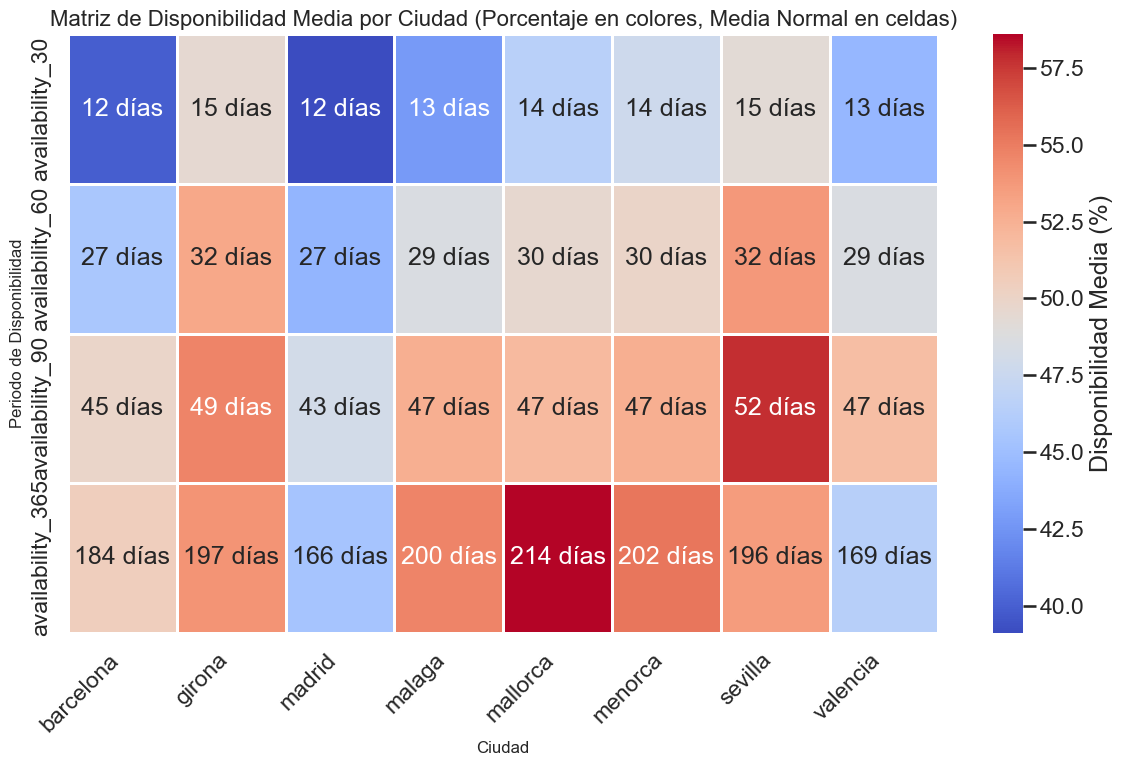

In [ ]:
grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje)

#### Densidad de distribucion

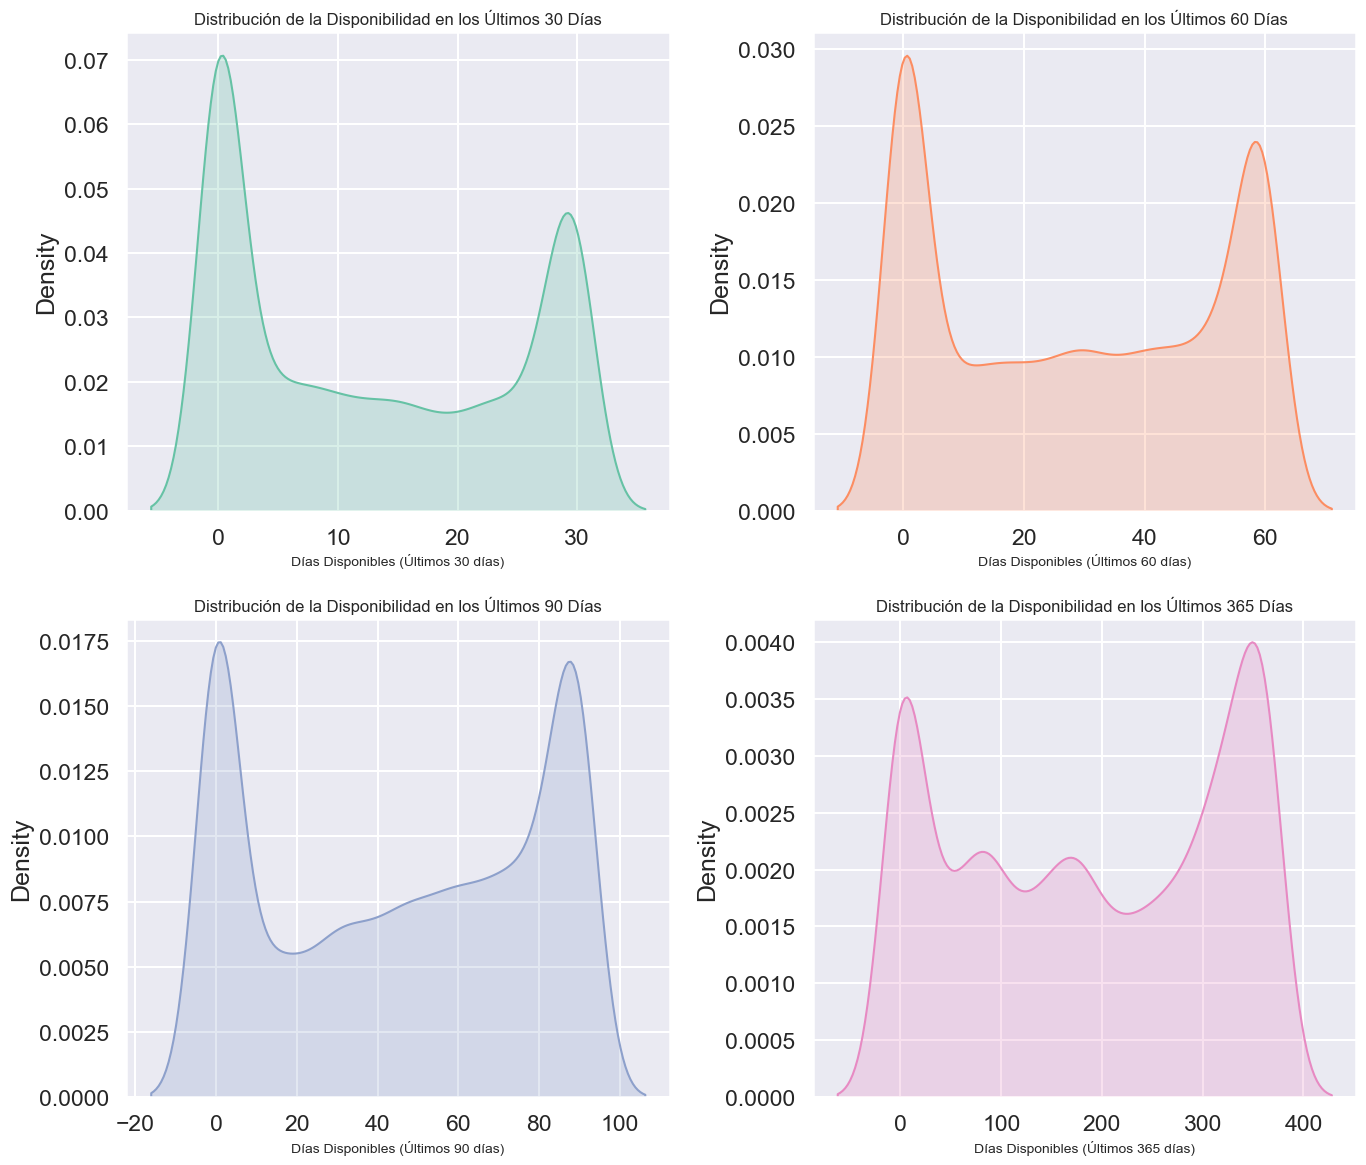

In [ ]:
distribucion_disponibilidad_kde(df, colores)

In [ ]:
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Creamos una pivot table con 'city' como √≠ndice, aplicando la funci√≥n mean para cada columna
availability_matrix = df.pivot_table(
    index='city',
    values=availability_cols,
    aggfunc='mean'
)

print(availability_matrix)

           availability_30  availability_365  availability_60  availability_90
city                                                                          
barcelona        11.983407        184.348451        27.353614        44.897124
girona           14.859164        197.033693        31.798518        49.189353
madrid           11.736620        165.561502        26.610329        43.281221
malaga           12.836978        199.578529        29.174950        47.385686
mallorca         13.944304        213.845570        29.733544        46.726582
menorca          14.331797        201.820276        29.967742        47.382488
sevilla          14.779352        195.775304        32.255061        52.030364
valencia         13.350877        169.274854        29.134503        46.522417


## Marketing

### Quin √©s el preu mitj√† dels allotjaments per tipus d'allotjament a cada ciutat?

In [ ]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Renombrar las columnas para mayor claridad
precio_medio.columns = ['Ciudad', 'Tipo de alojamiento', 'Precio medio']

# Formatear el precio medio con 2 decimales y separador de miles
precio_medio['Precio medio'] = precio_medio['Precio medio'].apply(lambda x: f"{x:,.2f}‚Ç¨")

# Mostrar todas los resultados
print(precio_medio)

       Ciudad Tipo de alojamiento Precio medio
0   barcelona     Entire home/apt    1,261.57‚Ç¨
1   barcelona          Hotel room    1,150.00‚Ç¨
2   barcelona        Private room      471.48‚Ç¨
3   barcelona         Shared room      451.03‚Ç¨
4      girona     Entire home/apt    1,258.80‚Ç¨
5      girona          Hotel room      672.73‚Ç¨
6      girona        Private room      680.61‚Ç¨
7      girona         Shared room      150.00‚Ç¨
8      madrid     Entire home/apt      967.60‚Ç¨
9      madrid          Hotel room      842.86‚Ç¨
10     madrid        Private room      479.39‚Ç¨
11     madrid         Shared room      706.67‚Ç¨
12     malaga     Entire home/apt      836.88‚Ç¨
13     malaga          Hotel room      622.50‚Ç¨
14     malaga        Private room      369.46‚Ç¨
15     malaga         Shared room      143.33‚Ç¨
16   mallorca     Entire home/apt    1,787.80‚Ç¨
17   mallorca          Hotel room    1,620.59‚Ç¨
18   mallorca        Private room      882.76‚Ç¨
19   mallorca         

In [ ]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Crear la tabla pivote
tabla_pivote = precio_medio.pivot_table(index='city', columns='room_type', values='price', aggfunc='mean')

# Formatear el precio medio con 2 decimales, separador de miles y s√≠mbolo de euro
tabla_pivote = tabla_pivote.applymap(lambda x: f"{x:,.2f}‚Ç¨" if pd.notnull(x) else x)

# Para reemplazar por 0 si NaN
tabla_pivote = tabla_pivote.fillna('0.00‚Ç¨')

# Mostrar la tabla pivote resultante
print(tabla_pivote)

room_type Entire home/apt Hotel room Private room Shared room
city                                                         
barcelona       1,261.57‚Ç¨  1,150.00‚Ç¨      471.48‚Ç¨     451.03‚Ç¨
girona          1,258.80‚Ç¨    672.73‚Ç¨      680.61‚Ç¨     150.00‚Ç¨
madrid            967.60‚Ç¨    842.86‚Ç¨      479.39‚Ç¨     706.67‚Ç¨
malaga            836.88‚Ç¨    622.50‚Ç¨      369.46‚Ç¨     143.33‚Ç¨
mallorca        1,787.80‚Ç¨  1,620.59‚Ç¨      882.76‚Ç¨     437.50‚Ç¨
menorca         1,724.85‚Ç¨      0.00‚Ç¨    1,197.89‚Ç¨       0.00‚Ç¨
sevilla         1,054.34‚Ç¨    819.09‚Ç¨      563.14‚Ç¨     120.00‚Ç¨
valencia          811.23‚Ç¨    770.00‚Ç¨      328.70‚Ç¨     203.33‚Ç¨


C:\Users\diego\AppData\Local\Temp\ipykernel_14504\3302454918.py:8: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



## Experiencia de clientes

### Quina √©s la puntuaci√≥ mitjana donada pels usuaris als allotjaments tur√≠stics, i quin percentatge d'allotjaments tenen una avaluaci√≥ general m√©s gran de 80 a cada ciutat?


#### Puntuaci√≥n media de los usuarios

In [ ]:
media_valor = df['review_scores_value'].mean()
print(f"Puntuaci√≥n media otorgada por los usuarios: {media_valor:.2f}")

Puntuaci√≥n media otorgada por los usuarios: 91.39


#### Porcentaje de alojamientos por ciudad que superan una puntuaci√≥n de 80

In [ ]:
# Crear una columna booleana para marcar los que superan 80
df['supera_80'] = df['review_scores_value'] > 80

# Agrupar por ciudad y calcular el porcentaje
porcentaje_por_ciudad = (
    df.groupby('city')['supera_80']
    .mean().sort_values(ascending=False) * 100
).round(2)

# Convertir la Series en un DataFrame con columnas nombradas
porcentaje_por_ciudad = porcentaje_por_ciudad.reset_index()
porcentaje_por_ciudad.columns = ['city', 'supera_80']  # Renombrar columnas para claridad


print(pd.DataFrame(porcentaje_por_ciudad))

        city  supera_80
0    sevilla      78.95
1   valencia      71.93
2     malaga      70.18
3     madrid      66.24
4  barcelona      61.06
5    menorca      51.15
6   mallorca      50.51
7     girona      46.36


#### Graficos

C:\Users\diego\AppData\Local\Temp\ipykernel_14504\1776001290.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




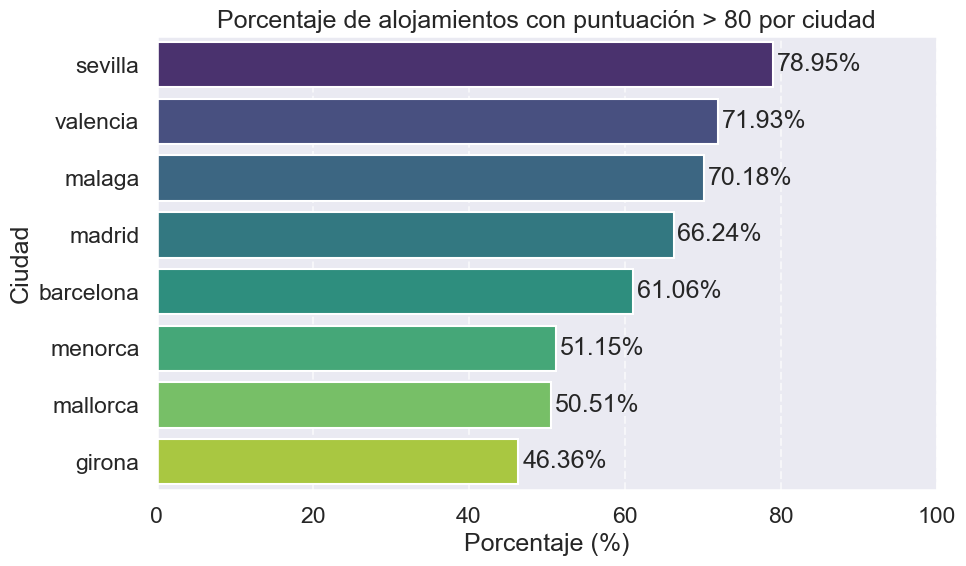

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=porcentaje_por_ciudad, x='supera_80', y='city', palette='viridis')

# Anotar porcentajes
for idx, row in enumerate(porcentaje_por_ciudad.itertuples()):
    plt.text(row.supera_80 + 0.5, idx, f"{row.supera_80}%", va='center')

# Ajustes visuales
plt.title('Porcentaje de alojamientos con puntuaci√≥n > 80 por ciudad')
plt.xlabel('Porcentaje (%)')
plt.ylabel('Ciudad')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Preguntas de negocio Sprint 2

## Operaciones

### Quin impacte t√© l'opci√≥ de reservar autom√†ticament (sense revisi√≥ del propietari) a la disponibilitat mitjana a cada ciutat?

In [ ]:
df_Book = df.groupby(['city', 'is_instant_bookable'])[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean().reset_index()
pivot_df_Book = df_Book.pivot(index='city', columns='is_instant_bookable', values=['availability_30', 'availability_60', 'availability_90', 'availability_365'])

In [ ]:
pivot_df_Book.columns = ['{}_{}'.format(col[0], col[1]) for col in pivot_df_Book.columns]

# 2. Renombrar las columnas a nombres m√°s descriptivos
pivot_df_Book = pivot_df_Book.rename(columns={
    'availability_30_VERDADERO': 'Disponibilidad 30 d√≠as (con reserva instant√°nea)',
    'availability_30_FALSO': 'Disponibilidad 30 d√≠as (sin reserva instant√°nea)',
    'availability_60_VERDADERO': 'Disponibilidad 60 d√≠as (con reserva instant√°nea)',
    'availability_60_FALSO': 'Disponibilidad 60 d√≠as (sin reserva instant√°nea)',
    'availability_90_VERDADERO': 'Disponibilidad 90 d√≠as (con reserva instant√°nea)',
    'availability_90_FALSO': 'Disponibilidad 90 d√≠as (sin reserva instant√°nea)',
    'availability_365_VERDADERO': 'Disponibilidad 365 d√≠as (con reserva instant√°nea)',
    'availability_365_FALSO': 'Disponibilidad 365 d√≠as (sin reserva instant√°nea)'
})


pivot_df_Book.round(2)

Disponibilidad 30 d√≠as (sin reserva instant√°nea)  \
city                                                          
barcelona                                             12.09   
girona                                                16.68   
madrid                                                11.71   
malaga                                                13.02   
mallorca                                              13.77   
menorca                                               15.05   
sevilla                                               13.74   
valencia                                              13.91   

           Disponibilidad 30 d√≠as (con reserva instant√°nea)  \
city                                                          
barcelona                                             11.87   
girona                                                13.75   
madrid                                                11.75   
malaga                                                12.77   
mallorca                                              14.05   
menorca                                               13.75   
sevilla                                               15.23   
valencia                                              12.88   

           Disponibilidad 60 d√≠as (sin reserva instant√°nea)  \
city                                                          
barcelona                                             27.17   
girona                                                35.53   
madrid                                                25.64   
malaga                                                29.41   
mallorca                                              29.91   
menorca                                               30.85   
sevilla                                               30.19   
valencia                                              30.39   

           Disponibilidad 60 d√≠as (con reserva instant√°nea)  \
city                                                          
barcelona                                             27.54   
girona                                                29.52   
madrid                                                27.31   
malaga                                                29.09   
mallorca                                              29.63   
menorca                                               29.26   
sevilla                                               33.14   
valencia                                              28.08   

           Disponibilidad 90 d√≠as (sin reserva instant√°nea)  \
city                                                          
barcelona                                             44.19   
girona                                                55.27   
madrid                                                41.12   
malaga                                                47.99   
mallorca                                              47.57   
menorca                                               48.64   
sevilla                                               49.22   
valencia                                              47.98   

           Disponibilidad 90 d√≠as (con reserva instant√°nea)  \
city                                                          
barcelona                                             45.63   
girona                                                45.48   
madrid                                                44.84   
malaga                                                47.15   
mallorca                                              46.23   
menorca                                               46.37   
sevilla                                               53.24   
valencia                                              45.29   

           Disponibilidad 365 d√≠as (sin reserva instant√°nea)  \
city                                                           
barcelona                                             177.99   
girona             

In [ ]:
# Coeficiente de disponibilidad
pivot_df_Book['Coeficiente (30 d√≠as)'] = (
    pivot_df_Book['Disponibilidad 30 d√≠as (sin reserva instant√°nea)'] - 
    pivot_df_Book['Disponibilidad 30 d√≠as (con reserva instant√°nea)']
) / (
    pivot_df_Book['Disponibilidad 30 d√≠as (con reserva instant√°nea)'] + 
    pivot_df_Book['Disponibilidad 30 d√≠as (sin reserva instant√°nea)']
)

pivot_df_Book['Coeficiente (60 d√≠as)'] = (
    pivot_df_Book['Disponibilidad 60 d√≠as (sin reserva instant√°nea)'] - 
    pivot_df_Book['Disponibilidad 60 d√≠as (con reserva instant√°nea)']
) / (
    pivot_df_Book['Disponibilidad 60 d√≠as (con reserva instant√°nea)'] + 
    pivot_df_Book['Disponibilidad 60 d√≠as (sin reserva instant√°nea)']
)

pivot_df_Book['Coeficiente (90 d√≠as)'] = (
    pivot_df_Book['Disponibilidad 90 d√≠as (sin reserva instant√°nea)'] - 
    pivot_df_Book['Disponibilidad 90 d√≠as (con reserva instant√°nea)']
) / (
    pivot_df_Book['Disponibilidad 90 d√≠as (con reserva instant√°nea)'] + 
    pivot_df_Book['Disponibilidad 90 d√≠as (sin reserva instant√°nea)']
)

pivot_df_Book['Coeficiente (365 d√≠as)'] = (
    pivot_df_Book['Disponibilidad 365 d√≠as (sin reserva instant√°nea)'] - 
    pivot_df_Book['Disponibilidad 365 d√≠as (con reserva instant√°nea)']
) / (
    pivot_df_Book['Disponibilidad 365 d√≠as (con reserva instant√°nea)'] + 
    pivot_df_Book['Disponibilidad 365 d√≠as (sin reserva instant√°nea)']
)

In [ ]:
pivot_df_Book[["Coeficiente (30 d√≠as)","Coeficiente (60 d√≠as)","Coeficiente (90 d√≠as)","Coeficiente (365 d√≠as)"]].round(2)

Coeficiente (30 d√≠as)  Coeficiente (60 d√≠as)  \
city                                                      
barcelona                   0.01                  -0.01   
girona                      0.10                   0.09   
madrid                     -0.00                  -0.03   
malaga                      0.01                   0.01   
mallorca                   -0.01                   0.00   
menorca                     0.05                   0.03   
sevilla                    -0.05                  -0.05   
valencia                    0.04                   0.04   

           Coeficiente (90 d√≠as)  Coeficiente (365 d√≠as)  
city                                                      
barcelona                  -0.02                   -0.04  
girona                      0.10                    0.13  
madrid                     -0.04                   -0.04  
malaga                      0.01                    0.00  
mallorca                    0.01                    0.02  
menorca                     0.02                    0.05  
sevilla                    -0.04                   -0.01  
valencia                    0.03                    0.04

In [ ]:
# Generar las posiciones para cada ciudad
ind = np.arange(len(pivot_df_Book))  

# Extraer los coeficientes para cada per√≠odo
coef30 = pivot_df_Book['Coeficiente (30 d√≠as)']
coef60 = pivot_df_Book['Coeficiente (60 d√≠as)']
coef90 = pivot_df_Book['Coeficiente (90 d√≠as)']
coef365 = pivot_df_Book['Coeficiente (365 d√≠as)']

fig = go.Figure()

# A√±adir cada grupo de barras con colores espec√≠ficos
fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef30,
    name='30 d√≠as',
    marker_color='#ADD8E6'  # Azul claro
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef60,
    name='60 d√≠as',
    marker_color='#87CEEB'  # Azul cielo
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef90,
    name='90 d√≠as',
    marker_color='#4682B4'  # Azul acero
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef365,
    name='365 d√≠as',
    marker_color='#00008B'  # Azul oscuro
))

fig.update_layout(
    title='Coeficiente por Ciudad y Per√≠odo',
    xaxis_title='Ciudad',
    yaxis_title='Coeficiente',
    barmode='group',  # Agrupar las barras
    yaxis=dict(range=[-0.2, 0.2]),  # Ajustar el rango del eje Y
    plot_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
    legend=dict(title='Per√≠odo', font=dict(size=12))
)

# A√±adir una l√≠nea horizontal en y=0
fig.add_shape(type='line',
              x0=0, x1=1, y0=0, y1=0,
              xref='paper', yref='y',
              line=dict(color='black', width=1))

fig.show()

In [ ]:
# Agrupar los datos por ciudad y calcular cu√°ntos pisos tienen reservas autom√°ticas y cu√°ntos no
tabla_resumen_Book = df.groupby(['city', 'is_instant_bookable']).size().unstack(fill_value=0)

# Renombrar las columnas 
tabla_resumen_Book.columns = ['Sin Reserva Autom√°tica', 'Con Reserva Autom√°tica']

# Recalcular las columnas de porcentaje
tabla_resumen_Book['% Con Reserva Autom√°tica'] = (tabla_resumen_Book['Con Reserva Autom√°tica'] / tabla_resumen_Book[['Sin Reserva Autom√°tica', 'Con Reserva Autom√°tica']].sum(axis=1)) * 100
tabla_resumen_Book['% Sin Reserva Autom√°tica'] = (tabla_resumen_Book['Sin Reserva Autom√°tica'] / tabla_resumen_Book[['Sin Reserva Autom√°tica', 'Con Reserva Autom√°tica']].sum(axis=1)) * 100

# Aplicar estilo con formato para porcentajes redondeados y con s√≠mbolo %
tabla_resumen_Book_styled = tabla_resumen_Book[['% Con Reserva Autom√°tica', '% Sin Reserva Autom√°tica']].style.format({
    '% Con Reserva Autom√°tica': '{:.2f}%',  # 2 decimales con s√≠mbolo %
    '% Sin Reserva Autom√°tica': '{:.2f}%'   # 2 decimales con s√≠mbolo %
}).background_gradient(cmap='Blues')  # A√±adir gradiente de color

tabla_resumen_Book_styled


In [ ]:
tabla_resumen_Book

Sin Reserva Autom√°tica  Con Reserva Autom√°tica  \
city                                                        
barcelona                    1377                    1335   
girona                        562                     922   
madrid                        893                    1237   
malaga                        140                     363   
mallorca                      589                     991   
menorca                        97                     120   
sevilla                       149                     345   
valencia                      235                     278   

           % Con Reserva Autom√°tica  % Sin Reserva Autom√°tica  
city                                                           
barcelona                 49.225664                 50.774336  
girona                    62.129380                 37.870620  
madrid                    58.075117                 41.924883  
malaga                    72.166998                 27.833002  
mallorca                  62.721519                 37.278481  
menorca                   55.299539                 44.700461  
sevilla                   69.838057                 30.161943  
valencia                  54.191033                 45.808967

In [ ]:
valores_unicos = df["is_instant_bookable"].unique()
valores_unicos

array(['FALSO', 'VERDADERO'], dtype=object)

In [ ]:
# Calcular la tasa de ocupaci√≥n promedio mensual por ciudad y por opci√≥n de reserva instant√°nea
occupancy_by_city_instant_booking = df.groupby(['city', 'is_instant_bookable'])['occupancy_rate'].mean().reset_index()

instant_booking = occupancy_by_city_instant_booking[occupancy_by_city_instant_booking['is_instant_bookable'] == 'True']
non_instant_booking = occupancy_by_city_instant_booking[occupancy_by_city_instant_booking['is_instant_bookable'] == 'False']

# Comparar la tasa de ocupaci√≥n promedio entre las dos categor√≠as
print("Tasa de ocupaci√≥n promedio por ciudad con y sin reserva instant√°nea:")
occupancy_by_city_instant_booking

Tasa de ocupaci√≥n promedio por ciudad con y sin reserva instant√°nea:


city is_instant_bookable  occupancy_rate
0   barcelona               FALSO       59.685306
1   barcelona           VERDADERO       60.436954
2      girona               FALSO       44.395018
3      girona           VERDADERO       54.172090
4      madrid               FALSO       60.955580
5      madrid           VERDADERO       60.821881
6      malaga               FALSO       56.595238
7      malaga           VERDADERO       57.447199
8    mallorca               FALSO       54.086022
9    mallorca           VERDADERO       53.181971
10    menorca               FALSO       49.828179
11    menorca           VERDADERO       54.166667
12    sevilla               FALSO       54.205817
13    sevilla           VERDADERO       49.236715
14   valencia               FALSO       53.645390
15   valencia           VERDADERO       57.062350

In [ ]:
occupancy_matrix = occupancy_by_city_instant_booking.pivot(index='city', columns='is_instant_bookable', values='occupancy_rate')

occupancy_matrix.rename(columns={'True': 'Instant Booking', 'False': 'No Instant Booking'}, inplace=True)

occupancy_matrix = occupancy_matrix.round(2)

# Funci√≥n para formatear los valores con '%'
def add_percentage_format(df):
    return df.map(lambda x: f"{x:.2f}%" if x != 0 else "0%")

occupancy_matrix = add_percentage_format(occupancy_matrix)

# Funci√≥n para resaltar el mayor y menor valor por fila
def highlight_min_max(s):
    styles = []
    for v in s:
        # Quitar el '%' para comparar los valores num√©ricos
        value = float(v.strip('%'))
        if value == max(float(v.strip('%')) for v in s):
            styles.append('background-color: darkblue; color: white;')
        elif value == min(float(v.strip('%')) for v in s):
            styles.append('background-color: lightblue; color: black;')
        else:
            styles.append('')
    return styles

styled_matrix = occupancy_matrix.style.apply(highlight_min_max, axis=1)

styled_matrix


## Marketing

### Quines caracter√≠stiques dels allotjaments (comoditats, capacitat i puntuaci√≥ de la zona) estan m√©s relacionades amb els preus a cada ciutat?


### 1. An√°lisis de correlaci√≥n general por ciudad
    Esto dar√°, para cada ciudad, qu√© variables tienen mayor correlaci√≥n con el precio.

In [ ]:
# Seleccionem les columnes rellevants
columnes_interessants = ['city', 'price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_location']
df_corr = df[columnes_interessants].dropna()

# Calcular la correlaci√≥ per ciutat
for ciutat in df_corr['city'].unique():
    print(f"\nüìç Ciutat: {ciutat.upper()}")
    sub_df = df_corr[df_corr['city'] == ciutat]
    correlacions = sub_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)
    print(correlacions)


üìç Ciutat: GIRONA
bedrooms                  0.636089
accommodates              0.631433
bathrooms                 0.594200
beds                      0.590282
review_scores_location    0.036720
Name: price, dtype: float64

üìç Ciutat: MALAGA
bedrooms                  0.529596
accommodates              0.520961
beds                      0.476394
bathrooms                 0.429480
review_scores_location    0.105608
Name: price, dtype: float64

üìç Ciutat: SEVILLA
accommodates              0.321542
beds                      0.273175
bedrooms                  0.257485
bathrooms                 0.233448
review_scores_location    0.085625
Name: price, dtype: float64

üìç Ciutat: MENORCA
bathrooms                 0.638240
accommodates              0.608181
bedrooms                  0.510102
beds                      0.406176
review_scores_location    0.046626
Name: price, dtype: float64

üìç Ciutat: VALENCIA
accommodates              0.480327
beds                      0.473672
bedrooms 

### Idem anterior correcci√≥n comentarios Abelardo
    Este c√≥digo:
    1.- Transforma amenities_list a una variable num√©rica (amenities_count).

    2.- Filtra columnas relevantes.

    3.- Calcula la correlaci√≥n entre el price y las dem√°s variables, por ciudad.

    4.- Ordena los resultados para ver cu√°l variable est√° m√°s correlacionada con el precio en cada ciudad.

In [ ]:
# Crear nueva columna num√©rica a partir de amenities_list
#df['amenities_count'] = df['amenities_list'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Asegura que todo sea string antes de contar
#df['amenities_count'] = df['amenities_list'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Soluci√≥n robusta y segura: cubre todos los casos posibles: None, float('nan'), strings, listas reales, etc.
def contar_amenities(x):
    if isinstance(x, list):  # Si ya es lista
        return len(x)
    elif isinstance(x, str):  # Si es string
        return len(x.split(','))
    else:
        return 0

df['amenities_count'] = df['amenities_list'].apply(contar_amenities)

# Columnas que queremos correlacionar con el precio
columnes_interessants = ['city', 'price', 'accommodates', 'amenities_count', 'review_scores_location']
df_corr = df[columnes_interessants].dropna()

# Calcular la correlaci√≥ per ciutat
for ciutat in df_corr['city'].unique():
    print(f"\nüìç Ciutat: {ciutat.upper()}")
    sub_df = df_corr[df_corr['city'] == ciutat]
    correlacions = sub_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)
    print(correlacions)


üìç Ciutat: GIRONA
accommodates              0.633069
amenities_count           0.102440
review_scores_location    0.036919
Name: price, dtype: float64

üìç Ciutat: MALAGA
accommodates              0.521112
review_scores_location    0.104167
amenities_count           0.102499
Name: price, dtype: float64

üìç Ciutat: SEVILLA
accommodates              0.323816
review_scores_location    0.083445
amenities_count          -0.058829
Name: price, dtype: float64

üìç Ciutat: MENORCA
accommodates              0.607040
amenities_count           0.109478
review_scores_location    0.054822
Name: price, dtype: float64

üìç Ciutat: VALENCIA
accommodates              0.481587
review_scores_location    0.062820
amenities_count           0.040214
Name: price, dtype: float64

üìç Ciutat: MALLORCA
accommodates              0.617416
amenities_count           0.116766
review_scores_location   -0.028777
Name: price, dtype: float64

üìç Ciutat: BARCELONA
accommodates              0.646930
amenities_c

### Paso 1: Calcular correlaci√≥n por ciudad (capacidad, camas, puntuaci√≥n de zona)

In [ ]:
# Utilizaremos la nueva columna num√©rica a partir de amenities_list creada en el punto anterior.

# Variables a analizar incluyendo amenities_count creado en el punto anterior
vars_interes = ['accommodates', 'amenities_count', 'review_scores_location']

# Crear un DataFrame vac√≠o para guardar las correlaciones
correlations_by_city = pd.DataFrame()

# Calcular correlaciones por ciudad
for city in df['city'].dropna().unique():
    sub_df = df[df['city'] == city]
    
    # Verificamos que haya suficientes datos v√°lidos para calcular correlaciones
    if sub_df[vars_interes + ['price']].dropna().shape[0] >= 2:
        corr = sub_df[vars_interes + ['price']].corr(numeric_only=True)['price'].drop('price')
        correlations_by_city[city.upper()] = corr

# Transponer para que las ciudades queden como √≠ndice
correlations_by_city = correlations_by_city.T

# Ordenar por nombre de ciudad
correlations_by_city = correlations_by_city.sort_index()

# Mostrar el DataFrame
print(correlations_by_city)


           accommodates  amenities_count  review_scores_location
BARCELONA      0.625356         0.193674               -0.015372
GIRONA         0.607764         0.107237                0.036919
MADRID         0.422751         0.057456                0.105204
MALAGA         0.526844         0.049004                0.104167
MALLORCA       0.413477         0.026683               -0.028777
MENORCA        0.571994         0.059184                0.054822
SEVILLA        0.339966        -0.077912                0.083445
VALENCIA       0.527983         0.039474                0.062820


### Paso 2: Visualizar tabla con fondo de color din√°mico

In [ ]:
styled_corr = correlations_by_city.style\
    .background_gradient(cmap='YlGnBu')\
    .format("{:.2f}")\
    .set_caption("üìä Correlaci√≥ entre caracter√≠stiques i preu per ciutat")

styled_corr

###  2. An√°lisis de comodidades (‚Äúamenities‚Äù) relacionadas con el precio
    Podemos analizar si ciertos servicios (como WiFi, aire acondicionado, parking, etc.) est√°n asociados a precios m√°s altos. Suponiendo que normalized_amenities es una lista:

### C√≥digo para crear normalized_amenities

In [ ]:
# Funci√≥n de limpieza b√°sica
def limpiar_amenities(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ''
    elif isinstance(x, list):
        items = x
    elif isinstance(x, str):
        items = [i.strip() for i in x.split(',')]
    else:
        return ''
    
    # Normalizar: quitar espacios, convertir a min√∫sculas, eliminar duplicados y ordenar
    items = [i.strip().lower() for i in items]
    return ', '.join(sorted(set(items)))

# Crear columna 'normalized_amenities'
df['normalized_amenities'] = df['amenities_list'].apply(limpiar_amenities)

In [ ]:
# Creamos una matriz binaria de presencia/ausencia de comodidades
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
amenities_matrix = vectorizer.fit_transform(df['normalized_amenities'].fillna(''))

# Convertir a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# A√±adir la columna de precio
amenities_df['price'] = df['price'].values

# Correlaci√≥n entre cada amenity y el precio
correlacions_amenities = amenities_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)

# Mostrar los 10 amenities con mayor correlaci√≥n positiva con el precio
print("\nüè∑Ô∏è Comoditats amb m√©s correlaci√≥ positiva amb el preu:")
print(correlacions_amenities.head(15))



c:\Users\diego\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'




üè∑Ô∏è Comoditats amb m√©s correlaci√≥ positiva amb el preu:
pool                        0.380342
indoor fireplace            0.272083
free parking on premises    0.264435
bbq grill                   0.230239
high chair                  0.221014
crib                        0.209419
dishwasher                  0.200141
garden or backyard          0.196758
tv                          0.182835
bathtub                     0.167919
private entrance            0.153428
family/kid friendly         0.152548
cable tv                    0.152402
air conditioning            0.149891
dryer                       0.143684
Name: price, dtype: float64


### C√≥digo para estilizar las correlaciones de amenities con el precio:

In [ ]:
# Crear un DataFrame de correlaci√≥n para las comodidades
styled_amenities = correlacions_amenities.head(15).to_frame().reset_index()
styled_amenities.columns = ['Amenity', 'Correlaci√≥n con el precio']

# Aplicar estilo
styled_amenities = styled_amenities.style\
    .background_gradient(subset=['Correlaci√≥n con el precio'], cmap='YlGnBu')\
    .format({'Correlaci√≥n con el precio': "{:.2f}"})\
    .set_caption("üè∑Ô∏è Comoditats amb m√©s correlaci√≥ amb el preu (15 primeres)")

# Mostrar el estilo
styled_amenities

### Paso 3: Calcular correlaci√≥n entre comodidades y precio

In [ ]:
# Limpiar datos y crear la matriz de comodidades
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
amenities_matrix = vectorizer.fit_transform(df['normalized_amenities'].fillna(''))

# Convertir a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# A√±adir precios
amenities_df['price'] = df['price'].values

# Calcular correlaci√≥n
correlation_series = amenities_df.corr()['price'].drop('price').sort_values(ascending=False)

# Convertir a DataFrame para visualizaci√≥n
amenities_corr_df = correlation_series.reset_index()
amenities_corr_df.columns = ['Amenidad', 'Correlaci√≥n con el precio']

c:\Users\diego\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



### Paso 4: Mostrar tabla formateada (comodidades)

In [ ]:
styled_amenities = amenities_corr_df.sort_values(by='Correlaci√≥n con el precio', ascending=False).head(15).style\
    .background_gradient(subset=['Correlaci√≥n con el precio'], cmap='Oranges')\
    .format({'Correlaci√≥n con el precio': "{:.2f}"})\
    .set_caption("üõãÔ∏è Comoditats amb m√©s correlaci√≥ amb el preu (15 primeres)")

styled_amenities

## Clientes

### Quins aspectes (precisi√≥ de detalls, higiene, check-in o comunicaci√≥) presenten difer√®ncies m√©s grans entre els allotjaments millor i pitjor valorats en l'avaluaci√≥ general?

El aspecto con la valoraci√≥n m√°s dispar es: Precisi√≥n    80.0
Limpieza     80.0
dtype: float64 con una diferencia de 80.00 puntos


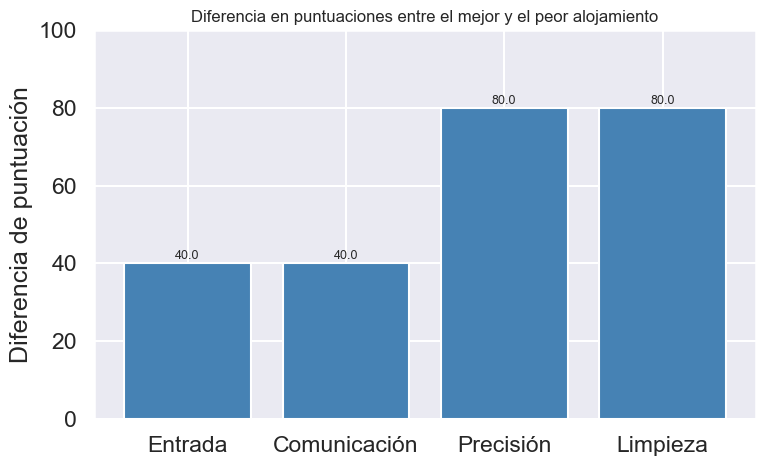

In [ ]:
# Seleccionamos las caracter√≠sticas evaluadas que nos interesan, eliminando localizaci√≥n    
cols.remove('review_scores_location')

# Eliminar filas con valores nulos en estas columnas y en la puntuaci√≥n global
df_clean = df.dropna(subset=cols + ['review_scores_value'])

# Calculamos el valor m√°s habitual de cada caracter√≠stica por puntuaci√≥n global
df_mediana = df_clean.groupby('review_scores_value')[cols].median().reset_index()
df_mediana

# Identificamos la valoraci√≥n m√°s alta y m√°s baja de los alojamientos
mejor = df_mediana.loc[df_mediana['review_scores_value'].idxmax()]
peor = df_mediana.loc[df_mediana['review_scores_value'].idxmin()]

# Calcular diferencias
diferencias = (mejor[cols] - peor[cols]).sort_values().rename(traducciones)

max_diferencia = diferencias.max()
max_items = diferencias[diferencias == max_diferencia]

print(f"El aspecto con la valoraci√≥n m√°s dispar es: {max_items} con una diferencia de {max_diferencia:.2f} puntos")

# Gr√°fico
plt.figure(figsize=(8, 5))
bars = plt.bar(diferencias.index, diferencias.values, color='steelblue')
plt.title('Diferencia en puntuaciones entre el mejor y el peor alojamiento', fontsize=12)
plt.ylabel('Diferencia de puntuaci√≥n')
plt.ylim(0, 100)

# Etiquetas encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()


In [ ]:
# Gr√°fica de radar plotly
#Trazamos la gr√°fica de radar

fig = px.line_polar(df, r=diferencias.values, theta=diferencias.index, range_r=(0, 100), line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(title_text='Diferencia global de valoraciones', title_x=0.5)

#A√±adimos los valores

fig.add_trace(go.Scatterpolar(
    r=diferencias.values,
    theta=diferencias.index,
    mode='markers+text',
    marker=dict(color='blue', size=5, symbol='circle'),
    text=diferencias.values,
    textposition='top center',
    name='Valores',
    showlegend=False
))

#Marcamos el valor m√°ximo

fig.add_trace(go.Scatterpolar(
    r=max_items.values,
    theta=max_items.index,
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Valor m√°ximo',
    showlegend=False
))

Segmentamos por ciudad

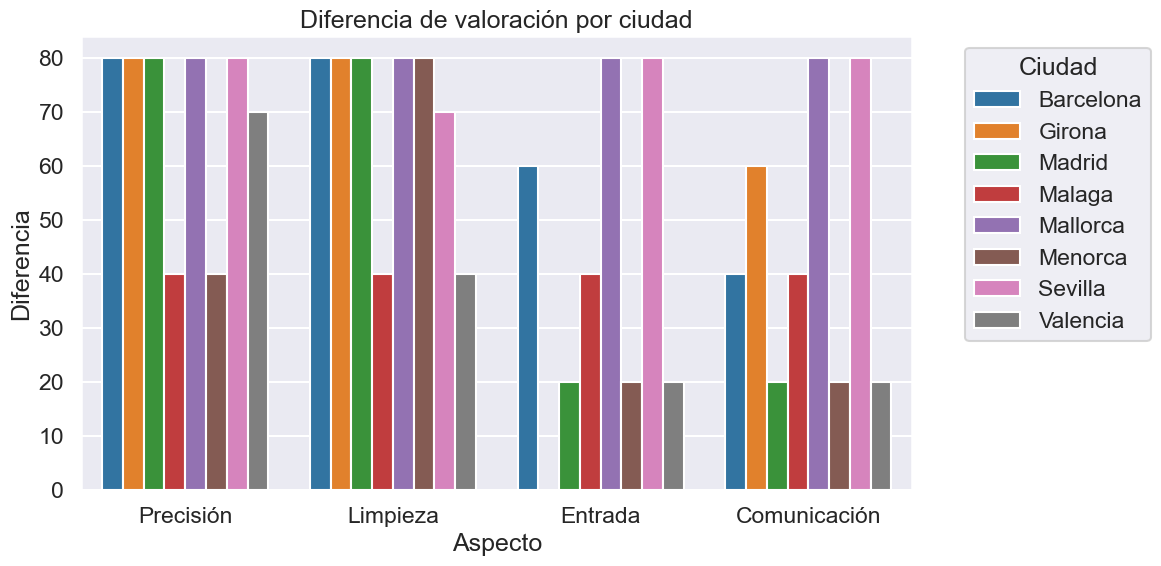

In [ ]:
# Filtrar filas con datos completos
df_clean = df.dropna(subset=cols + ['review_scores_value', 'city'])

# Agrupar por ciudad
grouped = df_clean.groupby('city') #Gr√°fica de barras apilada

#Agrupar por ciudad y calcular diferencias
records = []
for city, group in df_clean.groupby('city'):
    mejor = group.loc[group['review_scores_rating'].idxmax()]
    peor = group.loc[group['review_scores_rating'].idxmin()]
    diferencias = (mejor[cols] - peor[cols]).rename(traducciones)
    for aspecto, valor in diferencias.items():
        records.append({
            'Ciudad': city.capitalize(),
            'Aspecto': aspecto,
            'Diferencia': valor
        })

# Crear DataFrame en formato largo
long_df = pd.DataFrame(records)

# Crear gr√°fica
plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x='Aspecto', y='Diferencia', hue='Ciudad')

# Ajustes est√©ticos
plt.title("Diferencia de valoraci√≥n por ciudad")
plt.ylabel("Diferencia")
plt.legend(title="Ciudad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Segmentamos por tipo de alojamiento

In [ ]:
# Traducci√≥n tipo de alojamiento
trad_alojamientos = {
    'Entire home/apt' : 'Vivienda',
    'Hotel room' : 'Hotel',
    'Private room' : 'Hab. privada',
    'Shared room' : 'Hab. compartida'
}

# Filtrar filas con datos completos
df_clean = df.dropna(subset=cols + ['review_scores_value', 'room_type'])

# Agrupar solo por tipo de alojamiento
grouped = df_clean.groupby('room_type')

# Inicializar figura
fig = go.Figure()

# A√±adir una traza por tipo de alojamiento
for room_type, group in grouped:
    mejor = group.loc[group['review_scores_value'].idxmax()]
    peor = group.loc[group['review_scores_value'].idxmin()]
    diferencias = (mejor[cols] - peor[cols]).rename(traducciones)

    # Etiquetas m√°s limpias
    theta_labels = diferencias.index
    r_values = diferencias.values

    fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=theta_labels,
        fill='toself',
        name=trad_alojamientos.get(room_type, room_type),
        mode='lines+markers',
        opacity=0.6  # Mejora la legibilidad al superponer
    ))

# Configuraci√≥n del gr√°fico
fig.update_layout(
    autosize=False,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, df_clean[cols].max().max()]
        )
    ),
    title="Diferencia de valoraci√≥n por tipo de alojamiento",
    title_x=0.5,
    showlegend=True
)

fig.show()


# CSV

In [ ]:
df.to_csv("../Data/2025_04_28_Sprint03.csv", index=False)

In [ ]:
df

apartment_id                                               name  \
3092      15248525     appt dans villa ÔøΩ Llansa ,beau jardin,terrasse   
9896      44391173                              Hostal Escadarcs 1780   
7927      32088176  Two-level apartment, wifi, terrace, swimming pool   
9966      45803831                    Villa Solecito at Illes Balears   
9857      43993521  Apartment Sant Lluis,2 minutes walk from the b...   
...            ...                                                ...   
2635      13707226              Remarkable Value, Unbeatable Location   
3197      15713525    Nice room in classic eixample flat with balcony   
102         544995                 LUXURY HOUSE IN BCN NEAR THE BEACH   
405        1346199              Duplex Loft near Beach - Groups Offer   
2456      13166575                            Olivia Luxury Apartment   

                                            description    host_id  \
3092  Mon logement est proche de la plage et des com...   84213236   
9896  PequeÔøΩo hostal construido de 1780, situado en ...  358199210   
7927  Authentic 2 level apartment, located on the su...  240662122   
9966  Villa Solecito provides a most comfortable and...  345010290   
9857  Apartments located in the central part of Llor...   59318446   
...                                                 ...        ...   
2635  A spacious double bedroom with a balcony. It's...   80008404   
3197  Lugares de interÔøΩs: CervecerÔøΩa Catalana, Casa ...    3297768   
102   SPECIAL OFFER! LUXURY HOUSE IN BCN NEAR THE BE...    2556699   
405   Large loft 110mÔøΩ fully renovated and furnished...    6614322   
2456  Bright 85 m2 apartment with 2 double bedroom a...   10249776   

                     neighbourhood_name neighbourhood_district  \
3092                             LlanÔøΩÔøΩ                    NaN   
9896              Fontanals de Cerdanya                    NaN   
7927                      Lloret de Mar                    NaN   
9966                              MahÔøΩn                    NaN   
9857                      Lloret de Mar                    NaN   
...                                 ...                    ...   
2635                     el Barri GÔøΩtic           Ciutat Vella   
3197    l'Antiga Esquerra de l'Eixample               Eixample   
102       la Vila OlÔøΩmpica del Poblenou             Sant MartÔøΩ   
405   el Parc i la Llacuna del Poblenou             Sant MartÔøΩ   
2456             la Dreta de l'Eixample               Eixample   

            room_type  accommodates  bathrooms  bedrooms  ...  \
3092  Entire home/apt             6        1.0       2.0  ...   
9896     Private room            16        0.0       2.0  ...   
7927  Entire home/apt             4        1.0       1.0  ...   
9966  Entire home/apt            12        6.0       6.0  ...   
9857  Entire home/apt             6        1.0       2.0  ...   
...               ...           ...        ...       ...  ...   
2635     Private room             2        4.0       1.0  ...   
3197     Private room             1        2.0       1.0  ...   
102   Entire home/apt             6        3.0       3.0  ...   
405   Entire home/apt            10        1.0       2.0  ...   
2456  Entire home/apt             4        2.0       2.0  ...   

      reviews_per_month country       city  insert_date  \
3092               66.0   spain     girona   2021-02-27   
9896                NaN   spain     girona   2021-02-27   
7927               57.0   spain     girona   2021-02-27   
9966                NaN   spain    menorca   2021-02-27   
9857               29.0   spain     girona   2021-02-27   
...                 ...     ...        ...          ...   
2635               25.0   spain  barcelona   2017-01-04   
3197               52.0   spain  barcelona   2017-01-04   
102                39.0   spain  barcelona   2017-01-04   
405                 NaN   spain  barcelona   2017-01-04   
2456               34.0   spain  barcelon